In [ ]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

### 0.1 File Locations

In [1]:
# Sample 2
rgb_image_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/2011_09_29_drive_0071_sync/image_02/data/0000000527.png"
calib_dir_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/"
velo_file_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/kitti_data/2011_09_29/2011_09_29_drive_0071_sync/velodyne_points/data/0000000527.bin"
seg_image_path="/mnt/data4TbExt4/praveen_projects_data/Road Supervised Depth/semantic_maps/2011_09_29/2011_09_29_drive_0071_sync/image_02/0000000527.png"

### 0.2 Function to generate velodyne depth in camera coordinate system

In [2]:
import os
import cv2
from collections import Counter
import numpy as np

def load_velodyne_points(filename):
    """
    Load 3D point cloud from KITTI file format
    (adapted from https://github.com/hunse/kitti)
    """
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points

def read_calib_file(path):
    """
    Read KITTI calibration file
    (from https://github.com/hunse/kitti)
    """
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass
    return data

def sub2ind(matrixSize, rowSub, colSub):
    """
    Convert row, col matrix subscripts to linear indices
    """
    m, n = matrixSize
    return rowSub * (n - 1) + colSub - 1

def generate_depth_map(calib_dir, velo_filename, cam=2, vel_depth=False):
    """
    Generate a depth map from velodyne data
    """
    # load calibration files
    cam2cam = read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
    velo2cam = read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
    velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # get image shape
    im_shape = cam2cam['S_rect_0' + str(cam)][::-1].astype(np.int32)

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3, :3] = cam2cam['R_rect_0' + str(cam)].reshape(3, 3)
    P_rect = cam2cam['P_rect_0' + str(cam)].reshape(3, 4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    velo = load_velodyne_points(velo_filename)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape[:2]))
    depth[velo_pts_im[:, 1].astype(np.int32), velo_pts_im[:, 0].astype(np.int32)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds == dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth < 0] = 0
    return depth

### 1. Original RGB Image

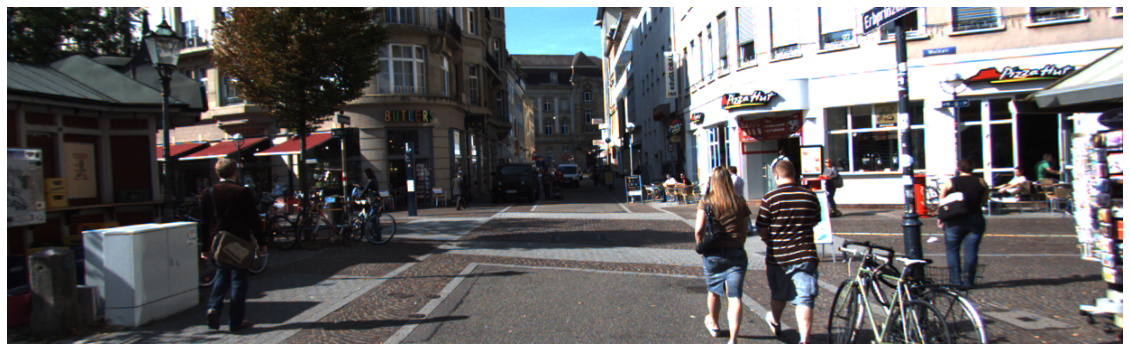

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_path = rgb_image_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the color image
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

### 2. Velodyne Depth Generation 

In [6]:
velodyne_depth_map_full_image = generate_depth_map(calib_dir=calib_dir_path, velo_filename=velo_file_path)

Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  79.39839828185306
Mean Depth:  0.6475349457682128


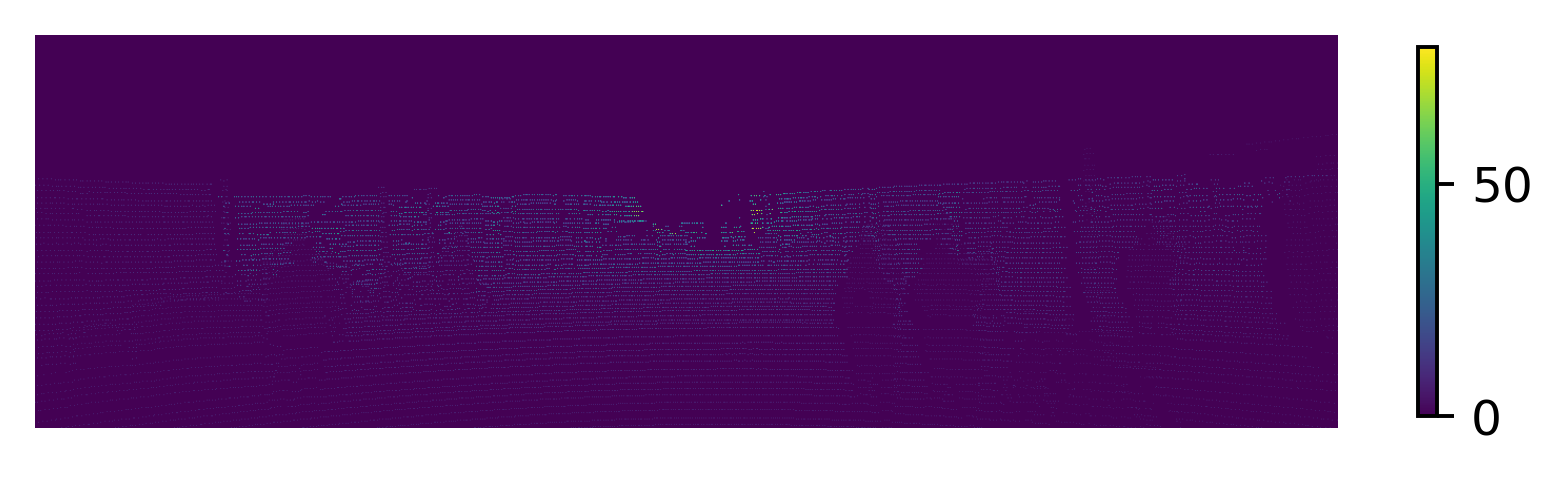

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Display
print("Shape: ", velodyne_depth_map_full_image.shape)
print("Min Depth: ", velodyne_depth_map_full_image.min())
print("Max Depth: ", velodyne_depth_map_full_image.max())
print("Mean Depth: ", velodyne_depth_map_full_image.mean())

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(velodyne_depth_map_full_image)
plt.colorbar(shrink=0.35)
plt.show()

### 3. Semantic Segmentation Map

Orig Sematic Shape (320, 1024)
Resize Sematic Shape (374, 1238)
(374, 1238)


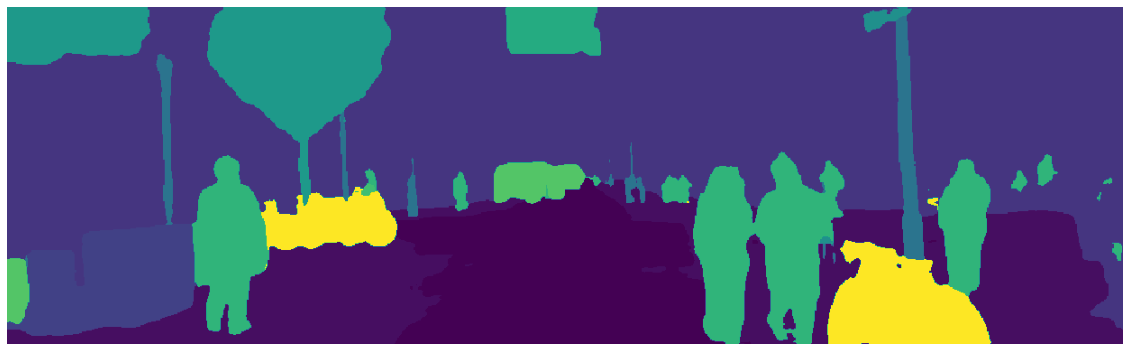

(374, 1238)


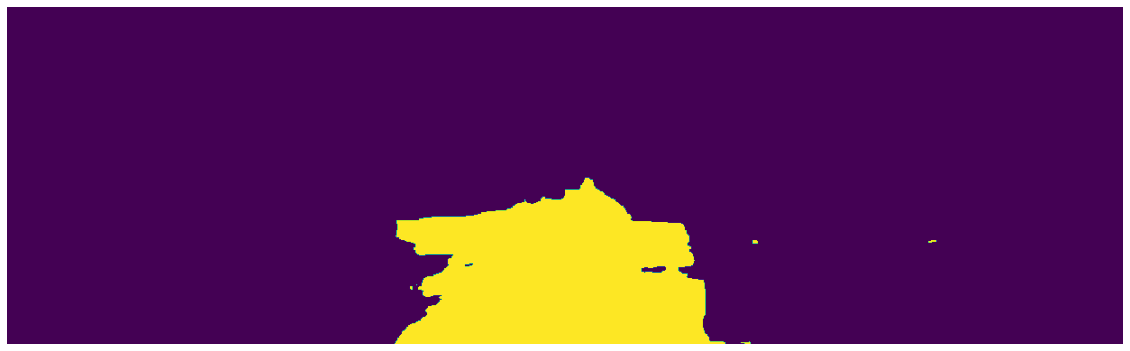

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load Image
image_path = seg_image_path
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
print("Orig Sematic Shape", image.shape)

#Resize
new_size = (1238, 374)
resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
print("Resize Sematic Shape", resized_image.shape)

# Display the masked color image
print(resized_image.shape)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(resized_image)
plt.axis('off')
plt.show()

#ground_labels = [6, 7, 8, 9, 10, 22]
ground_labels = [7]
# Create a masked image where all values except ground_labels are set to 0
Sem_gray_image_road = np.where(np.isin(resized_image, ground_labels), 7, 0)

# Display the masked color image
print(Sem_gray_image_road.shape)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(Sem_gray_image_road)
plt.axis('off')
plt.show()

### Velodyne Depth of Flat Surface

(374, 1238)
(374, 1238)
Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  47.983502844390394
Mean Depth:  0.11967942855436162


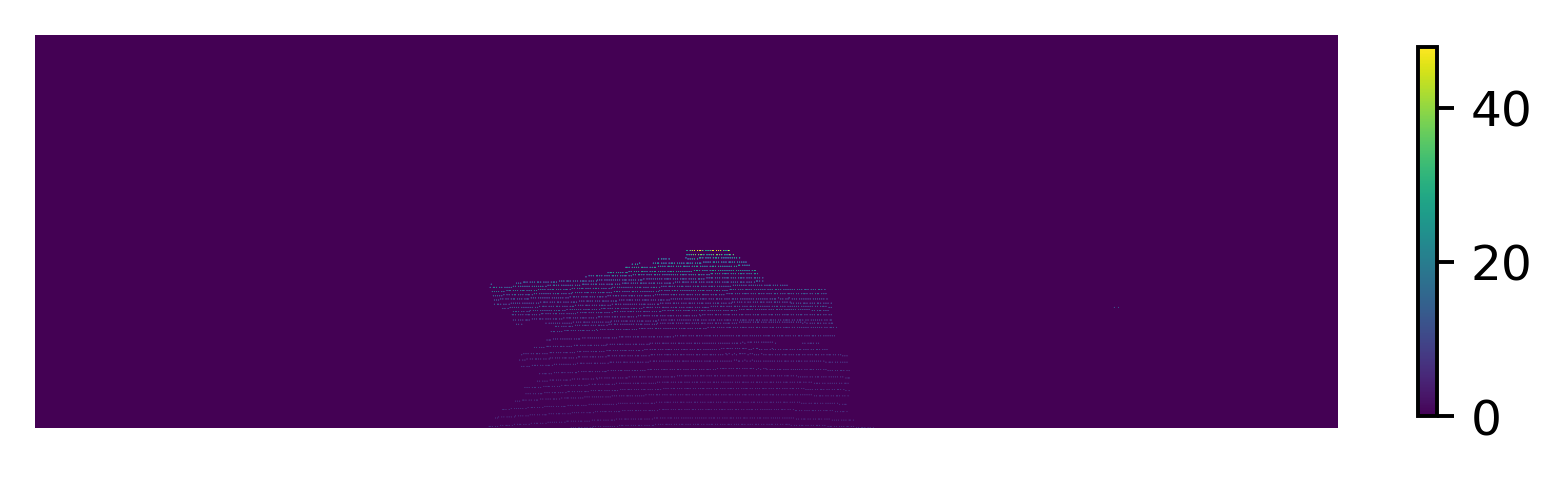

In [9]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
velodyne_depth_map_road=velodyne_depth_map_full_image.copy()

print(Sem_gray_image_road.shape)
print(velodyne_depth_map_road.shape)

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if Sem_gray_image_road[i, j]!=7 or velodyne_depth_map_full_image[i, j] < 0:
            velodyne_depth_map_road[i, j] = 0

# Display
print("Shape: ", velodyne_depth_map_road.shape)
print("Min Depth: ", velodyne_depth_map_road.min())
print("Max Depth: ",velodyne_depth_map_road.max())
print("Mean Depth: ",velodyne_depth_map_road.mean())

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(velodyne_depth_map_road)
plt.colorbar(shrink=0.35)
plt.show()

### 4. Physics Depth 

In [10]:
# estimate ground surface orientation from lidar point
# ground surface orientation estimate:
# n_x*(x-x0) + n_y*(y-y0) + n_z*(z-z0) = 0;

#get lidar 3d points
def depthToPt3d(d, x, y, f):
    r = np.array([x,y,f]) # ISO coordinate
    unit_r = r / np.linalg.norm(r)
    return d*r

# Rectified Image Dimensions
height = 374
width = 1238

# Extract Fx, Fy, Cx, and Cy
Fx = 7.183351e+02
Fy = 7.183351e+02

Cx = int(np.floor(6.003891e+02))
Cy = int(np.floor(1.815122e+02))

f = (Fx + Fy) / 2

# Create a depth array
map3d_f = np.zeros((3, height*width))

# Calculate depth for each pixel
idx = 0
for y in range(height):
    for x in range(width):
        x_custom = x - Cx
        y_custom = y - Cy
        d = velodyne_depth_map_road[y,x]
        if not d==0:
            map3d_f[:,idx] = depthToPt3d(d, x_custom, y_custom, f)
            idx = idx+1

map3d = np.delete(map3d_f,np.s_[idx:],axis = 1)
print(idx)
print(map3d.shape)

# centroid of 3D points:
centroid = map3d.mean(axis = 1)

print(map3d.shape[1])

H = np.zeros((3, map3d.shape[1]));

# estimate surface normal:
for i in range(map3d.shape[1]):
    H[:,i] = map3d[:,i] - centroid;

A = np.dot(H,H.T)

U, S, Vh = np.linalg.svd(A, full_matrices=True)

N = U[:,2]

print("surface normal:")
print(N)

# decompose surface normal to roll, pitch angle
pitchAngle = np.arcsin(N[2])
rollAngle = -np.arcsin(N[0]/np.cos(pitchAngle))

print(rollAngle,pitchAngle)

R_roll = np.array([[np.cos(rollAngle), -np.sin(rollAngle),0],
                    [np.sin(rollAngle),np.cos(rollAngle),0],
                    [0, 0, 1]]);

R_pitch = np.array([[1, 0, 0],
                    [0, np.cos(pitchAngle), -np.sin(pitchAngle)],
                    [0, np.sin(pitchAngle), np.cos(pitchAngle)]]);

R_g2l= np.dot(R_roll,R_pitch)
R_l2g = R_g2l.T

pt_g =  np.dot(R_l2g,map3d)

centroid_g = pt_g.mean(axis = 1)
height_l2g = centroid_g[1]

print("Rotation to ground:")
print(R_l2g)

print("height to ground:")
print(height_l2g)

4042
(3, 4042)
4042
surface normal:
[-0.02359655 -0.99971877  0.0023619 ]
0.023598806555507144 0.002361899380145799
Rotation to ground:
[[ 9.99721561e-01  2.35966162e-02  0.00000000e+00]
 [-2.35965504e-02  9.99718773e-01  2.36189718e-03]
 [ 5.57327815e-05 -2.36123954e-03  9.99997211e-01]]
height to ground:
1205.8863614243319


Shape:  (374, 1238)
Min Depth:  -817457.0945
Max Depth:  6165443.0246


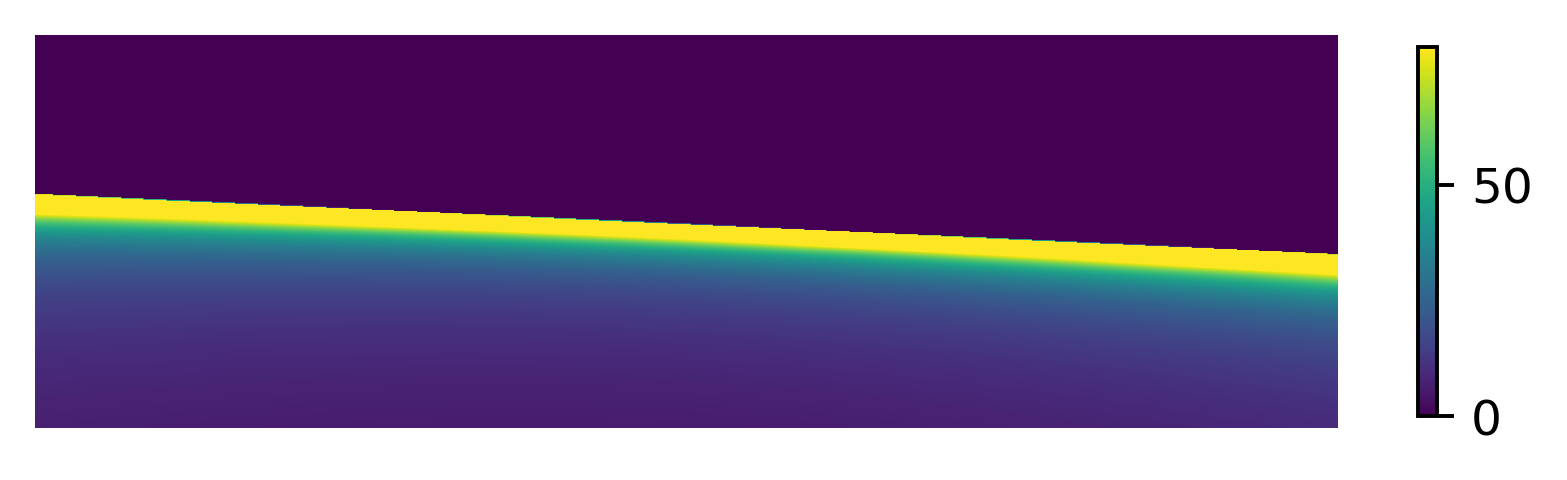

In [11]:
#S_rect_02: 1.238000e+03 3.740000e+02

#R_rect_02:
# 9.998896e-01 1.484154e-02 7.649204e-04 
#-1.484114e-02 9.998897e-01 -5.289052e-04 
#-7.726858e-04 5.174945e-04 9.999996e-01

#P_rect_02: 7.183351e+02 0.000000e+00 6.003891e+02 4.450382e+01 0.000000e+00 7.183351e+02 1.815122e+02 -5.951107e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.616315e-03

# calib_velo_to_cam.txt
R_lidar2cam = np.array([[7.755449e-03, -9.999694e-01, -1.014303e-03],
                        [2.294056e-03, 1.032122e-03, -9.999968e-01],
                        [9.999673e-01, 7.753097e-03, 2.301990e-03]])

R_img2iso = np.array([[0,-1, 0],[0, 0,-1],[1, 0, 0]]);
R_c2l = np.dot(R_img2iso.T,R_lidar2cam)

import numpy as np
import matplotlib.pyplot as plt
import cv2

# Rectified Image Dimensions
height = 374
width = 1238

# Create the R matrix
R_c02c2 = np.array([
    [ 9.998896e-01, 1.484154e-02,  7.649204e-04], 
    [-1.484114e-02, 9.998897e-01, -5.289052e-04], 
    [-7.726858e-04, 5.174945e-04,  9.999996e-01]
])

# rotation from camera 2 to ground = R_c02c2*R_c02l*R_l2g
R = np.dot(R_c02c2,np.dot(R_c2l,R_l2g))

# Function to calculate road depth
def road_depth(x, y):
    f = (Fx + Fy) / 2
    r = np.array([x, y, f])
    unit_r = r / np.linalg.norm(r)
    rc = np.matmul(R, unit_r)
    d = 1.65 / rc[1]
    return round(d, 4)

# Create a depth array
depth_array = np.zeros((1, height, width))

# Calculate depth for each pixel
for y in range(height):
    for x in range(width):
        x_custom = x - Cx 
        y_custom = y - Cy
        depth_array[0, y, x] = road_depth(x_custom, y_custom)

phy_depth_map_full_image= depth_array[0]

# Display
print("Shape: ", phy_depth_map_full_image.shape)
print("Min Depth: ", phy_depth_map_full_image.min())
print("Max Depth: ",phy_depth_map_full_image.max())

image = np.clip(phy_depth_map_full_image, 0.0000, 80) # Clipping just for visualization
fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(image)  
plt.colorbar(shrink=0.35)
plt.show()

### Physics Depth of Flat Surface

Data Type: <class 'numpy.ndarray'>
Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  132.959
Mean Depth:  1.2421173498743014


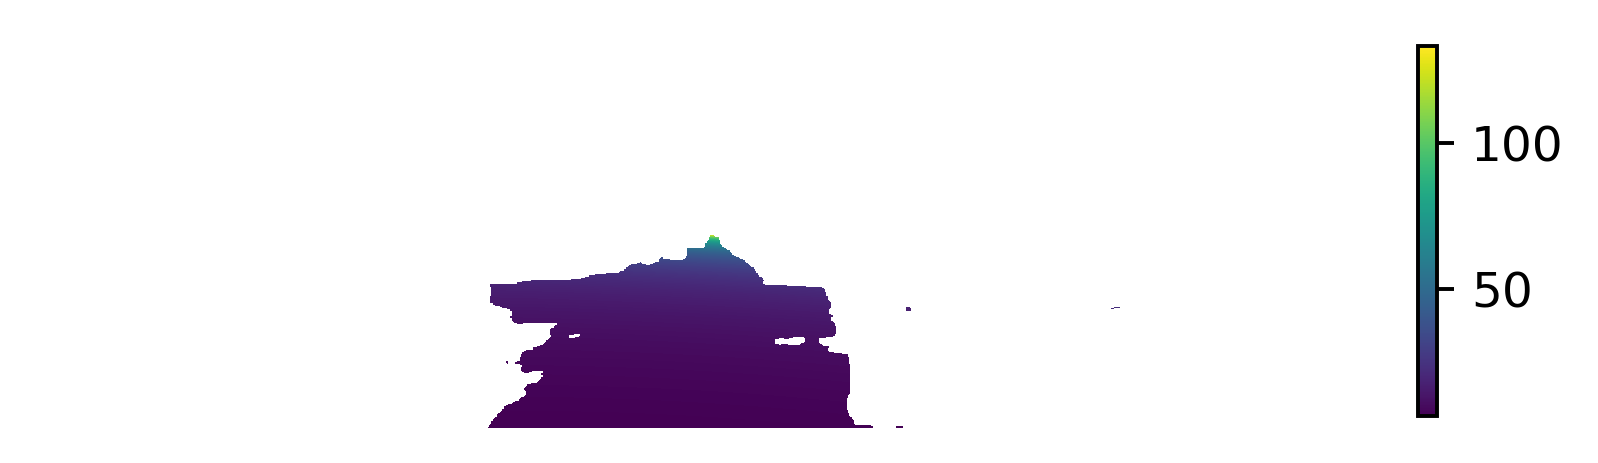

In [12]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
phy_depth_map_road=phy_depth_map_full_image.copy()

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if  Sem_gray_image_road[i, j]!=7 or phy_depth_map_full_image[i, j]< 0:
            phy_depth_map_road[i, j] = 0

# Masking zeros
masked_image = np.ma.masked_where((phy_depth_map_road == 0)|(phy_depth_map_road==0), phy_depth_map_road) # For Visualization Purpose

# Display
print("Data Type:", type(phy_depth_map_road))
print("Shape: ", phy_depth_map_road.shape)
print("Min Depth: ", phy_depth_map_road.min())
print("Max Depth: ",phy_depth_map_road.max())
print("Mean Depth: ",phy_depth_map_road.mean())

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(masked_image)
plt.colorbar(shrink=0.35)
plt.show()

### Error Histogram

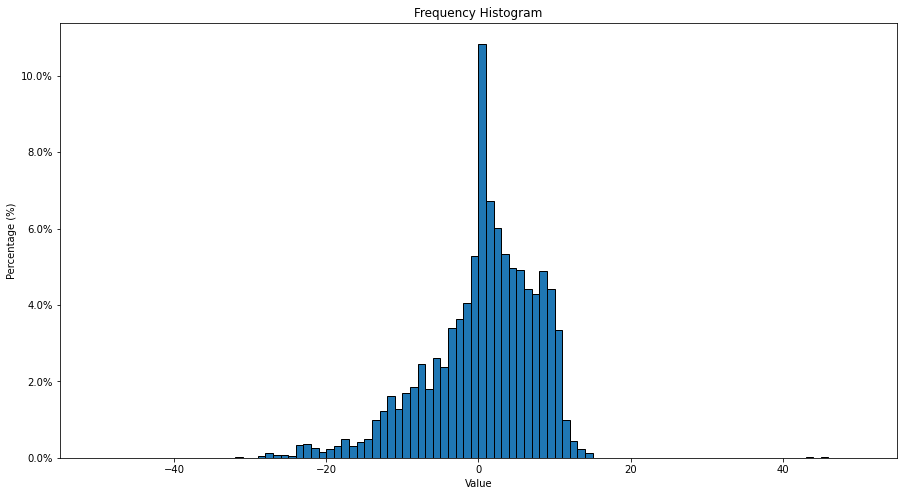

In [15]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Initialize frequency counter
freq_counter = Counter()

# Load Physics Depth
physics_depth_map = phy_depth_map_road
ld_depth_map = velodyne_depth_map_road

# Create an empty array with the same shape as the original depth maps
percentage_difference_map = np.zeros_like(ld_depth_map)

# Iterate over the depth maps
for i in range(ld_depth_map.shape[0]):
    for j in range(ld_depth_map.shape[1]):
        lidar_value = ld_depth_map[i, j]
        physics_value = physics_depth_map[i, j]

        # Check if either value is zero
        if lidar_value == 0 or physics_value == 0:
            percentage_difference = 0
        else:
            # Calculate the percentage difference and round to 2 decimals
            percentage_difference = round(((physics_value-lidar_value) / (physics_value)) * 100, 2)
            
        # Place the calculated value in the percentage difference map
        percentage_difference_map[i, j] = percentage_difference

# Flatten the array to work with 1D data
flattened_map = percentage_difference_map.flatten()
# Filter out zero values
non_zero_values = flattened_map[flattened_map != 0]

# Update frequency counter
for val in non_zero_values:
    if -50 < val < 50:
        freq_counter[int(val)] += 1

# Print and save frequency
total_count = sum(freq_counter.values())

for i in range(-50, 50):
    count = freq_counter.get(i, 0)
    #print(f"Range ({i}, {i+1}): {count} values")

# Plot histogram
plt.figure(figsize=(15, 8))  # Increase the size of the histogram
plt.hist(list(freq_counter.elements()), bins=range(-50, 51), edgecolor='black', density=True)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))

plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Frequency Histogram')
plt.show()

In [22]:
import numpy as np

def calculate_depth_metrics(predicted_depth_map, ground_truth_depth_map, depth_threshold=20):
    # Ensure calculations are only done where both depths are non-zero and predicted depth is less than the threshold
    mask = (ground_truth_depth_map > 0) & (predicted_depth_map > 0) & (predicted_depth_map < depth_threshold) 
    valid_pixel_count = np.sum(mask)
    predicted_depth_map = predicted_depth_map[mask]
    ground_truth_depth_map = ground_truth_depth_map[mask]

    # Avoid division by zero and log of zero
    if np.any(ground_truth_depth_map <= 0) or np.any(predicted_depth_map <= 0):
        raise ValueError("Depth values should be positive and non-zero.")

    # Calculate errors
    error = np.abs(ground_truth_depth_map - predicted_depth_map)
    percentage_error = np.mean(error / ground_truth_depth_map) * 100

    # Metrics
    abs_rel = np.mean(np.abs(ground_truth_depth_map - predicted_depth_map) / ground_truth_depth_map)
    sq_rel = np.mean(((ground_truth_depth_map - predicted_depth_map) ** 2) / ground_truth_depth_map)
    rmse = np.sqrt(np.mean((ground_truth_depth_map - predicted_depth_map) ** 2))
    rmse_log = np.sqrt(np.mean((np.log(ground_truth_depth_map) - np.log(predicted_depth_map)) ** 2))
    delta1 = (np.maximum((ground_truth_depth_map / predicted_depth_map), (predicted_depth_map / ground_truth_depth_map)) < 1.25).mean()
    delta2 = (np.maximum((ground_truth_depth_map / predicted_depth_map), (predicted_depth_map / ground_truth_depth_map)) < 1.25 ** 2).mean()
    delta3 = (np.maximum((ground_truth_depth_map / predicted_depth_map), (predicted_depth_map / ground_truth_depth_map)) < 1.25 ** 3).mean()

    # Additional metrics
    max_error = np.max(error)
    min_error = np.min(error)
    mean_error = np.mean(error)
    abs_mean_error = np.mean(np.abs(error))
    predicted_depth_range = (np.min(predicted_depth_map), np.max(predicted_depth_map))
    ground_truth_depth_range = (np.min(ground_truth_depth_map), np.max(ground_truth_depth_map))

    return {
        "Valid Pixel Count": valid_pixel_count,
        "AbsRel": abs_rel,
        "Sq Rel": sq_rel,
        "RMSE": rmse,
        "RMSE log": rmse_log,
        "δ < 1.25": delta1,
        "δ < 1.25^2": delta2,
        "δ < 1.25^3": delta3,
        "Max Error": max_error,
        "Min Error": min_error,
        "Mean Error": mean_error,
        "Percentage Error": percentage_error,
        "Predicted Depth Range": predicted_depth_range,
        "Ground Truth Depth Range": ground_truth_depth_range
    }

predicted_depth_map = phy_depth_map_road
ground_truth_depth_map = velodyne_depth_map_road

metrics = calculate_depth_metrics(predicted_depth_map, ground_truth_depth_map)
# Print all metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Valid Pixel Count: 3468
AbsRel: 0.057176628679658975
Sq Rel: 0.07187945441420983
RMSE: 1.0913528154994891
RMSE log: 0.07202235972398673
δ < 1.25: 0.9953863898500577
δ < 1.25^2: 1.0
δ < 1.25^3: 1.0
Max Error: 6.12293537597855
Min Error: 2.579372460864704e-05
Mean Error: 0.7338898821638883
Percentage Error: 5.717662867965897
Predicted Depth Range: (6.242, 19.9882)
Ground Truth Depth Range: (5.966515892520317, 24.70563537597855)


## Depth Filling

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load Image
image_path = seg_image_path
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

#Resize
new_size = (1238, 374) 
resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

# Display the masked color image
#print(resized_image.shape)
#fig, ax = plt.subplots(figsize=(20, 20))
#plt.imshow(resized_image)
#plt.axis('off')
#plt.show()

ground_labels = [6, 7, 8, 9, 10, 22]

# Create a masked image where all values except ground_labels are set to 0
Sem_gray_image_road = np.where(np.isin(resized_image, ground_labels), 7, 0)

# Display the masked color image
#print(Sem_gray_image_road.shape)
#fig, ax = plt.subplots(figsize=(20, 20))
#plt.imshow(Sem_gray_image_road)
#plt.axis('off')
#plt.show()

In [17]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
phy_depth_map_road=phy_depth_map_full_image.copy()

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if  Sem_gray_image_road[i, j]!=7 or phy_depth_map_full_image[i, j]< 0:
            phy_depth_map_road[i, j] = 0

# Masking zeros
masked_image = np.ma.masked_where((phy_depth_map_road == 0)|(phy_depth_map_road==0), phy_depth_map_road) # For Visualization Purpose

# Display
# print("Data Type:", type(phy_depth_map_road))
# print("Shape: ", phy_depth_map_road.shape)
# print("Min Depth: ", phy_depth_map_road.min())
# print("Max Depth: ",phy_depth_map_road.max())
# print("Mean Depth: ",phy_depth_map_road.mean())

# fig = plt.figure(dpi=350)
# plt.axis('off')
# plt.imshow(masked_image)
# plt.colorbar(shrink=0.35)
# plt.show()

In [18]:
import numpy as np
def fill_depth(depth_map):
    # Get the shape of the depth map
    rows, cols = depth_map.shape
    # Loop through each column
    for col in range(cols):
        last_non_zero_depth = 0
        for row in range(rows-1, -1, -1):  # Start from the bottom
            if depth_map[row][col] != 0:
                last_non_zero_depth = depth_map[row][col]
            elif last_non_zero_depth != 0:
                depth_map[row][col] = last_non_zero_depth
    return depth_map

In [19]:

import numpy as np
from scipy.ndimage import binary_dilation

def get_contacting_labels(sem_seg_image, target_labels):
    # Create a binary mask for the target labels
    target_mask = np.isin(sem_seg_image, target_labels)
    
    # Dilate the target mask to find neighboring pixels
    dilated_target_mask = binary_dilation(target_mask)
    
    # Find the labels of the objects that are in contact with the target labels
    contacting_mask = dilated_target_mask & ~target_mask
    contacting_labels = np.unique(sem_seg_image[contacting_mask])
    
    # Remove label (21: Vegetation and 23: Sky )from the contacting labels
    contacting_labels = contacting_labels[(contacting_labels != 21) & (contacting_labels != 23)]
    
    return contacting_labels

def extend_depth_map(sem_seg_image, phy_depth_map_road, target_labels, contacting_labels):
    output_depth_map = phy_depth_map_road.copy()
    
    for label in contacting_labels:
        # Create a mask for the current label
        label_mask = sem_seg_image == label
        
        # Identify the boundary where the label is in contact with the target labels
        boundary_mask = label_mask & binary_dilation(np.isin(sem_seg_image, target_labels))
        
        # For each column in the image
        for col in range(sem_seg_image.shape[1]):
            # If there's a boundary in this column
            if np.any(boundary_mask[:, col]):
                # Find the depth values of the target_labels in this column
                target_depths = phy_depth_map_road[:, col][np.isin(sem_seg_image[:, col], target_labels) & (phy_depth_map_road[:, col] > 0)]
                
                # If there are valid target depths, take the nearest one
                if target_depths.size > 0:
                    nearest_depth = target_depths.min()
                    
                    # Propagate this depth value vertically for the entire object of the current label in this column
                    output_depth_map[label_mask[:, col], col] = nearest_depth
    return output_depth_map

In [20]:
target_labels = [6, 7, 8, 9, 10, 22]
sem_seg_image = resized_image
contacting_labels = get_contacting_labels(sem_seg_image, target_labels)
phy_depth_map_road_extended = extend_depth_map(sem_seg_image, phy_depth_map_road, target_labels, contacting_labels)

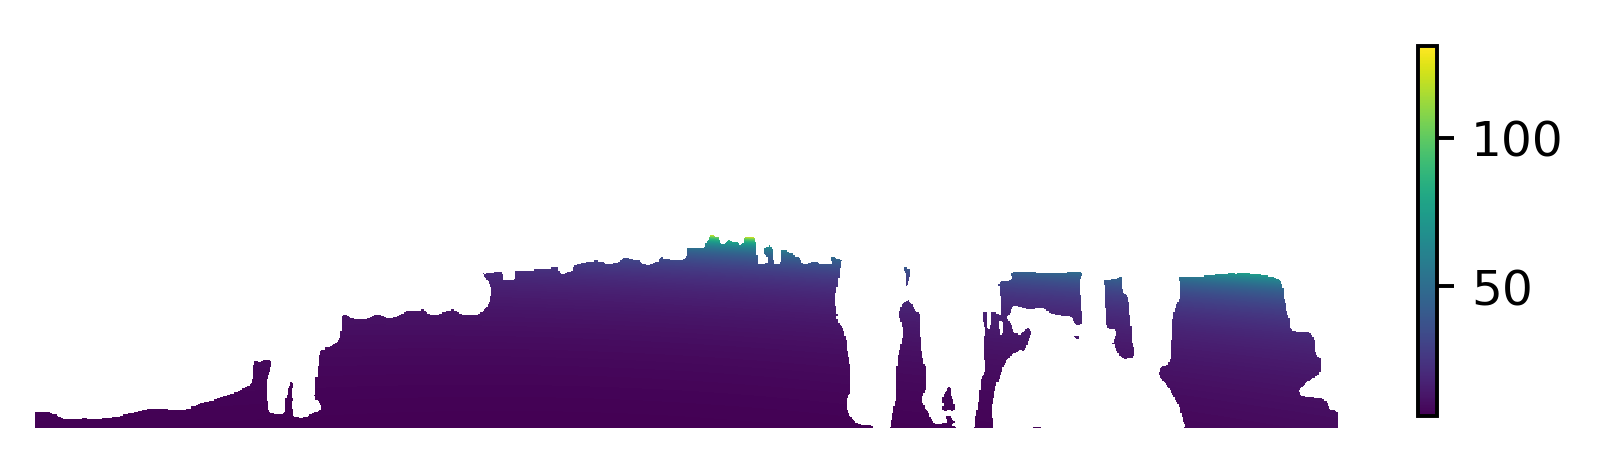

In [21]:
# Masking zeros
a = np.ma.masked_where((phy_depth_map_road == 0)|(phy_depth_map_road==0), phy_depth_map_road) # For Visualization Purpose

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(a)
plt.colorbar(shrink=0.35)
plt.show()

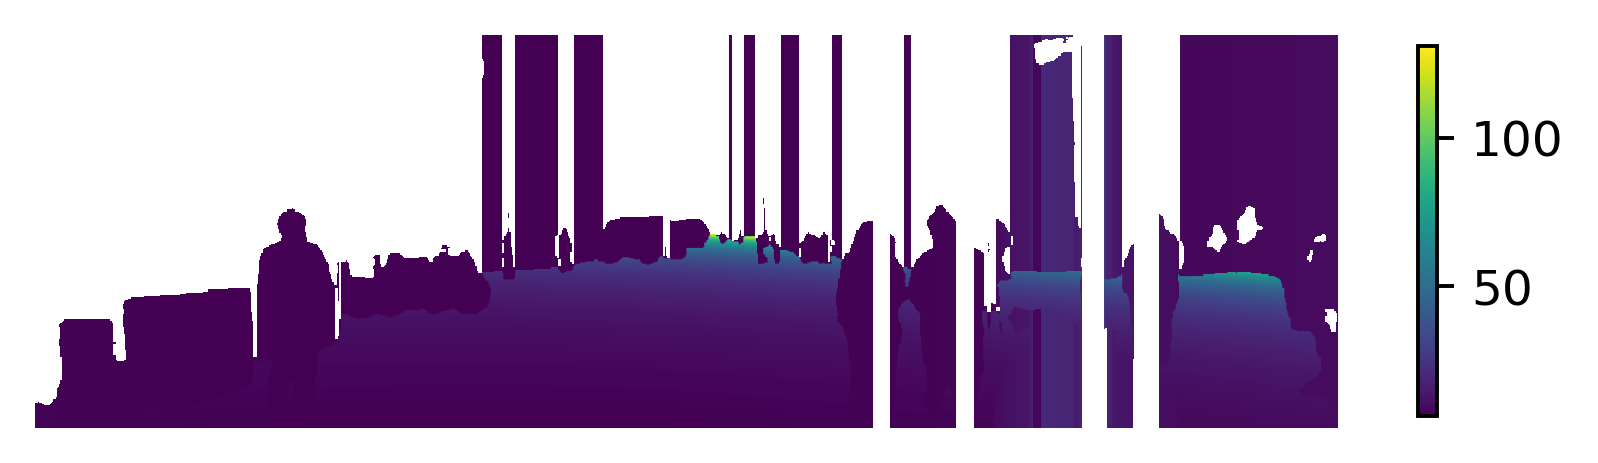

In [22]:
# Masking zeros
b = np.ma.masked_where((phy_depth_map_road_extended == 0)|(phy_depth_map_road_extended==0), phy_depth_map_road_extended) # For Visualization Purpose

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(b)
plt.colorbar(shrink=0.35)
plt.show()

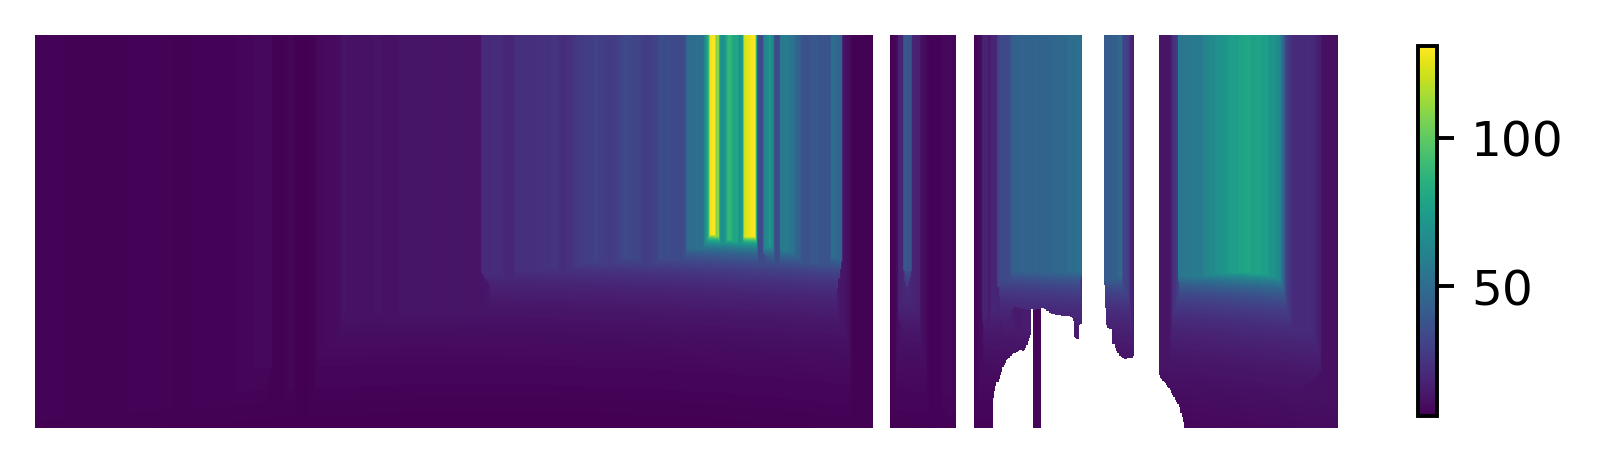

In [23]:
x=phy_depth_map_road.copy()
filled_depth_map = fill_depth(x)

# Masking zeros
c = np.ma.masked_where((filled_depth_map == 0)|(filled_depth_map==0), filled_depth_map)

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(c)
plt.colorbar(shrink=0.35)
plt.show()

In [24]:
import numpy as np

# Step 2: Create a new placeholder depth map with depth values as zero
final_depth_map = np.zeros_like(phy_depth_map_road_extended)

# Step 3: Populate the final_depth_map based on the conditions
# a. When phy_depth_map_road_extended and phy_depth_map_road depths are equal
equal_depths = np.where(phy_depth_map_road_extended == phy_depth_map_road)
final_depth_map[equal_depths] = phy_depth_map_road_extended[equal_depths]

# b. When phy_depth_map_road_extended and phy_depth_map_road depths are not equal
not_equal_depths = np.where(phy_depth_map_road_extended != phy_depth_map_road)
final_depth_map[not_equal_depths] = filled_depth_map[not_equal_depths]


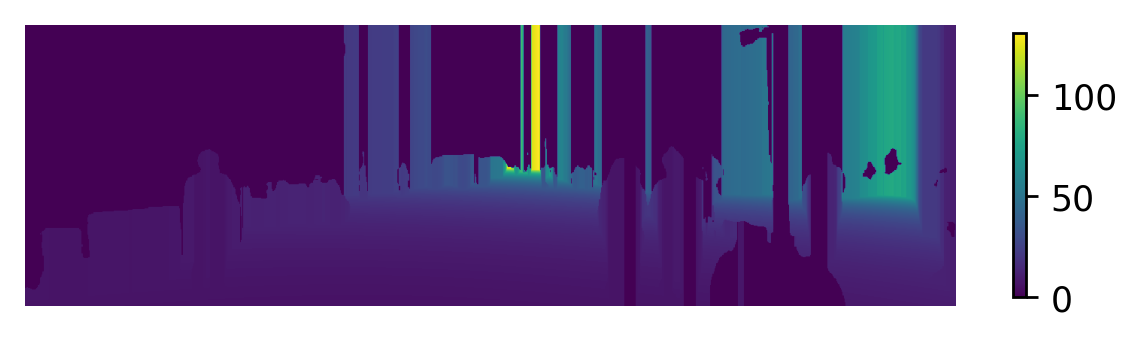

In [25]:
fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(final_depth_map)
plt.colorbar(shrink=0.35)
plt.show()

print contact labels:  [11 12 17 20 24 26 33]


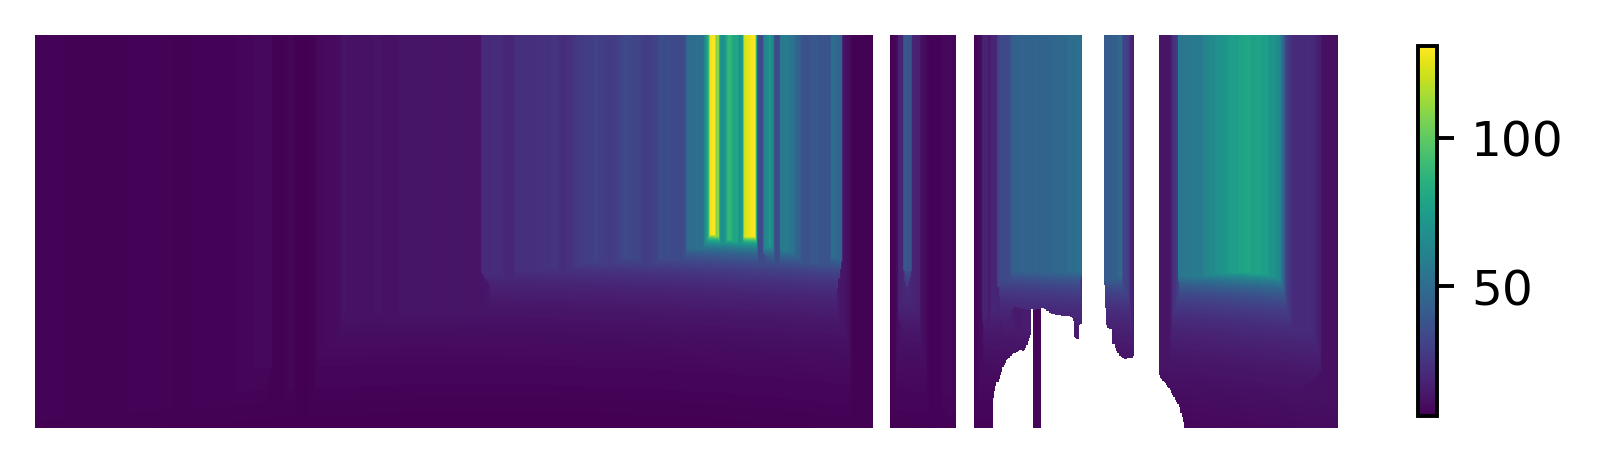

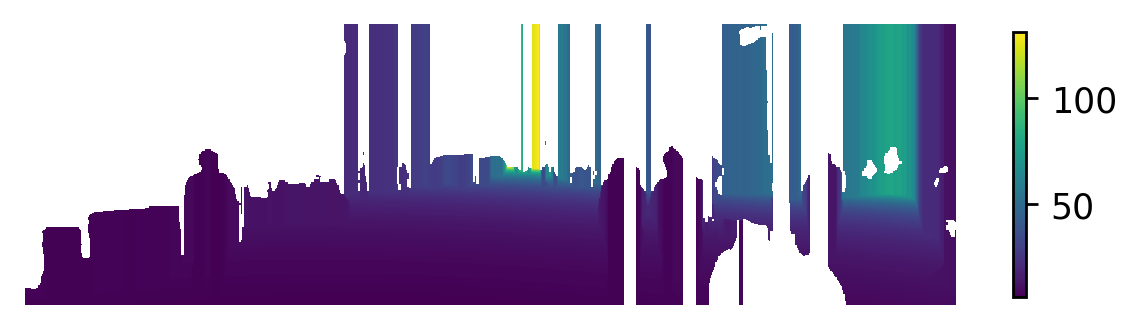

In [26]:
import numpy as np
def fill_depth(depth_map):
    # Get the shape of the depth map
    rows, cols = depth_map.shape
    # Loop through each column
    for col in range(cols):
        last_non_zero_depth = 0
        for row in range(rows-1, -1, -1):  # Start from the bottom
            if depth_map[row][col] != 0:
                last_non_zero_depth = depth_map[row][col]
            elif last_non_zero_depth != 0:
                depth_map[row][col] = last_non_zero_depth
    return depth_map

import numpy as np
from scipy.ndimage import binary_dilation

def get_contacting_labels(sem_seg_image, target_labels):
    # Create a binary mask for the target labels
    target_mask = np.isin(sem_seg_image, target_labels)
    
    # Dilate the target mask to find neighboring pixels
    dilated_target_mask = binary_dilation(target_mask)
    
    # Find the labels of the objects that are in contact with the target labels
    contacting_mask = dilated_target_mask & ~target_mask
    contacting_labels = np.unique(sem_seg_image[contacting_mask])
    
    # Remove label (21: Vegetation and 23: Sky )from the contacting labels
    contacting_labels = contacting_labels[(contacting_labels != 21) & (contacting_labels != 23)]
    print("print contact labels: ", contacting_labels)
    return contacting_labels

def extend_depth_map(sem_seg_image, phy_depth_map_road, target_labels, contacting_labels):
    output_depth_map = phy_depth_map_road.copy()
    
    for label in contacting_labels:
        # Create a mask for the current label
        label_mask = sem_seg_image == label
        
        # Identify the boundary where the label is in contact with the target labels
        boundary_mask = label_mask & binary_dilation(np.isin(sem_seg_image, target_labels))
        
        # For each column in the image
        for col in range(sem_seg_image.shape[1]):
            # If there's a boundary in this column
            if np.any(boundary_mask[:, col]):
                # Find the depth values of the target_labels in this column
                target_depths = phy_depth_map_road[:, col][np.isin(sem_seg_image[:, col], target_labels) & (phy_depth_map_road[:, col] > 0)]
                
                # If there are valid target depths, take the nearest one
                if target_depths.size > 0:
                    nearest_depth = target_depths.min()
                    
                    # Propagate this depth value vertically for the entire object of the current label in this column
                    output_depth_map[label_mask[:, col], col] = nearest_depth
    return output_depth_map

target_labels = [6, 7, 8, 9, 10, 22]
sem_seg_image = resized_image
contacting_labels = get_contacting_labels(sem_seg_image, target_labels)
phy_depth_map_road_extended = extend_depth_map(sem_seg_image, phy_depth_map_road, target_labels, contacting_labels)

import numpy as np

x=phy_depth_map_road.copy()
filled_depth_map = fill_depth(x)

# Masking zeros
c = np.ma.masked_where((filled_depth_map == 0)|(filled_depth_map==0), filled_depth_map)

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(c)
plt.colorbar(shrink=0.35)
plt.show()

# Step 2: Create a new placeholder depth map with depth values as zero
final_depth_map = np.zeros_like(phy_depth_map_road_extended)

# Step 3: Populate the final_depth_map based on the conditions
# a. When phy_depth_map_road_extended and phy_depth_map_road depths are equal
equal_depths = np.where(phy_depth_map_road_extended == phy_depth_map_road)
final_depth_map[equal_depths] = phy_depth_map_road_extended[equal_depths]

# b. When phy_depth_map_road_extended and phy_depth_map_road depths are not equal
not_equal_depths = np.where(phy_depth_map_road_extended != phy_depth_map_road)
final_depth_map[not_equal_depths] = filled_depth_map[not_equal_depths]

k = np.ma.masked_where((final_depth_map == 0)|(final_depth_map==0), final_depth_map)

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(k)
plt.colorbar(shrink=0.35)
plt.show()


### Step 1: Edge Extrapolation

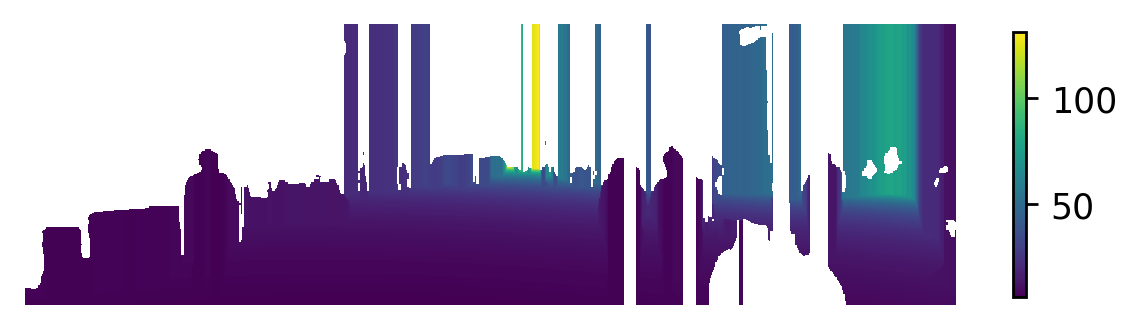

In [27]:
# Masking zeros
d = np.ma.masked_where((final_depth_map == 0)|(final_depth_map==0), final_depth_map)

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(d)
plt.colorbar(shrink=0.35)
plt.show()

### Step 2: Nearest Neighbor Inpainting

Non-zero pixels unchanged: True
Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  130.7589


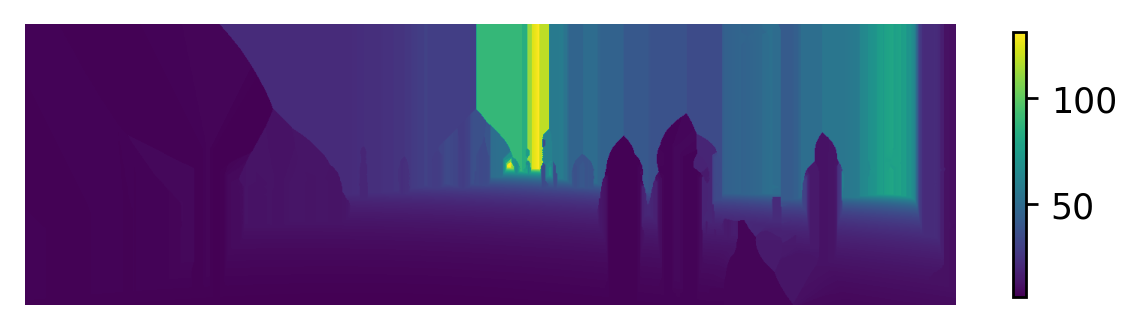

In [28]:
import numpy as np
import scipy
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt

def inpaint(img):
    h, w = img.shape[:2]
    mask_zero = np.where(img == 0)
    mask_non_zero = np.where(img != 0)
    
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    xym_zero = np.vstack((xx[mask_zero], yy[mask_zero])).T
    xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
    
    img_values_non_zero = img[mask_non_zero]
    
    interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
    img_interp_values = interp(xym_zero[:,0], xym_zero[:,1])
    
    img_out = np.copy(img)
    img_out[mask_zero] = img_interp_values
    
    # Check if non-zero pixels are unchanged
    unchanged_non_zero_pixels = np.array_equal(img_out[mask_non_zero], img[mask_non_zero])
    print("Non-zero pixels unchanged:", unchanged_non_zero_pixels)
    
    return img_out

# Assume final_depth_map is your input image
inpaint_depth = inpaint(final_depth_map)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)
plt.colorbar(shrink=0.35)
plt.show()

### Step 3: Telea + Nearest Neighbor Inpainting

* Propagation: For every pixel inside the missing region, its value is estimated based on a weighted combination of its neighbors. The weight for each neighbor is computed based on three factors:

        1. The distance from the current pixel (based on the distance function).
        2. The gradient (or directional rate of change) at the neighboring pixel.
        3. The geometric distance from the neighboring pixel.

Number of zero-valued pixels before inpainting: 208362
Number of zero pixels inpainted by Telea inpainting: 207146
Number of zero pixels inpainted by Nearest Neighbor interpolation: 1216
Non-zero pixels unchanged: True
Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  5.946837 Max after inpainting:  130.7589


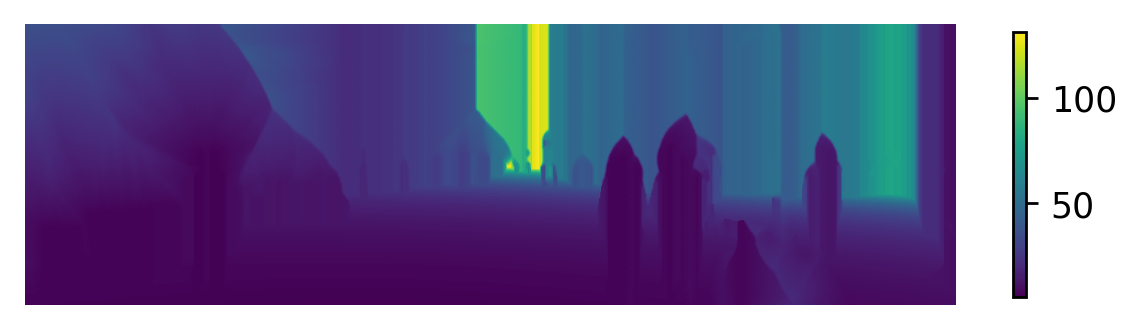

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

def inpaint(img):
    # Convert the image to 32-bit float if necessary
    img_float = img.astype(np.float32) if img.dtype != np.float32 else img

    # Count the number of zero-valued pixels before inpainting
    zero_pixels_before = np.sum(img_float == 0)
    print(f"Number of zero-valued pixels before inpainting: {zero_pixels_before}")

    # Create a binary mask where zero-valued pixels are set to 1 and non-zero-valued pixels are set to 0
    mask = (img_float == 0).astype(np.uint8)

    # Use the Telea inpainting method to inpaint the zero-valued pixels
    inpainted_img = cv2.inpaint(img_float, mask, 3, cv2.INPAINT_TELEA)

    # Count the number of zero-valued pixels inpainted by Telea inpainting
    telea_inpainted_pixels = zero_pixels_before - np.sum(inpainted_img == 0)
    print(f"Number of zero pixels inpainted by Telea inpainting: {telea_inpainted_pixels}")

    # If there are still zero-valued pixels remaining, use Nearest Neighbor interpolation
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])

    # Count the number of zero-valued pixels inpainted by Nearest Neighbor interpolation
    nn_inpainted_pixels = (zero_pixels_before - np.sum(inpainted_img == 0)) - telea_inpainted_pixels
    print(f"Number of zero pixels inpainted by Nearest Neighbor interpolation: {nn_inpainted_pixels}")
    
    # Check if non-zero pixels are unchanged
    mask_non_zero = np.where(img_float != 0)
    unchanged_non_zero_pixels = np.array_equal(inpainted_img[mask_non_zero], img_float[mask_non_zero])
    print(f"Non-zero pixels unchanged: {unchanged_non_zero_pixels}")

    return inpainted_img

# Assume final_depth_map is your input image
inpaint_depth = inpaint(final_depth_map)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

### Step 4: Telea + Nearest Neighbor Inpainting (within each label separately)

(374, 1238)


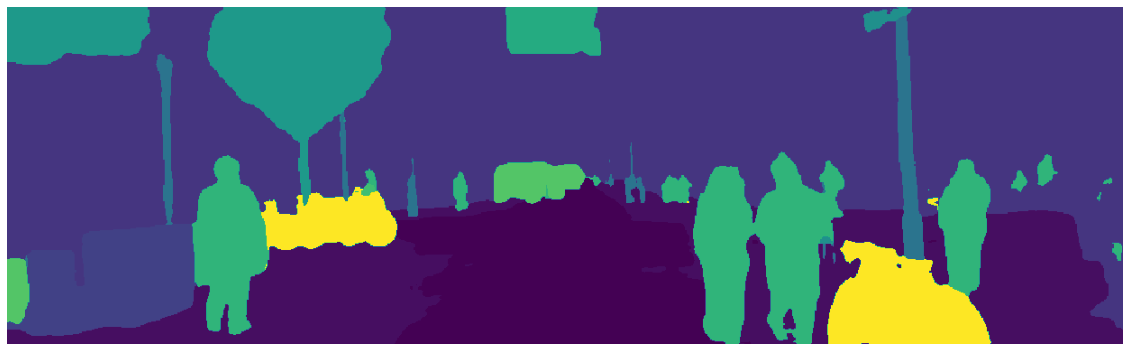

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load Image
image_path = seg_image_path
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

#Resize
new_size = (1238, 374) 
sem_seg_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

# Display the masked color image
print(sem_seg_image.shape)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(sem_seg_image)
plt.axis('off')
plt.show()

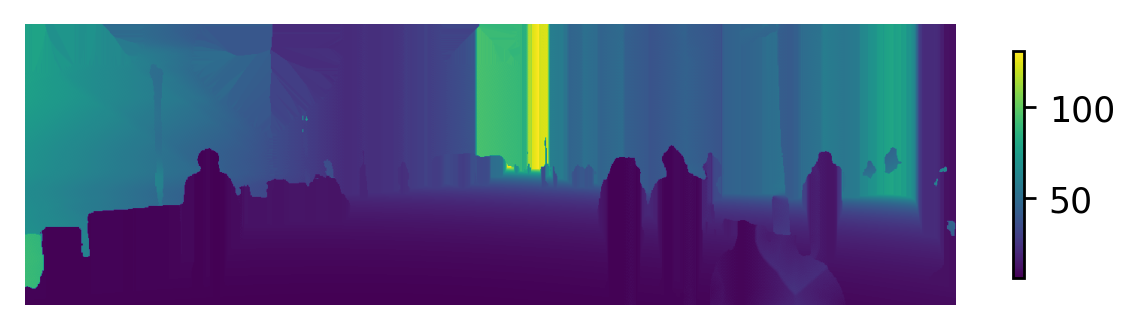

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

def inpaint_object_level(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label in unique_labels:
        object_mask = (sem_seg_image == label)
        object_depth = inpainted_img * object_mask
        
        non_zero_object_depth = object_depth[object_mask]
        if np.any(non_zero_object_depth):
            # Create a binary mask of zero-valued pixels for the object
            object_zero_mask = (object_depth == 0).astype(np.uint8)
            
            # Ensure the object depth is a supported data type for cv2.inpaint
            object_depth_32f = object_depth.astype(np.float32)
            
            # Inpaint the object using the Telea method
            inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
            
            # Update the inpainted image with the inpainted object
            inpainted_img[object_mask] = inpainted_object[object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_object_level(final_depth_map, sem_seg_image)
#print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
#print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.3)
plt.show()

Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  130.7589


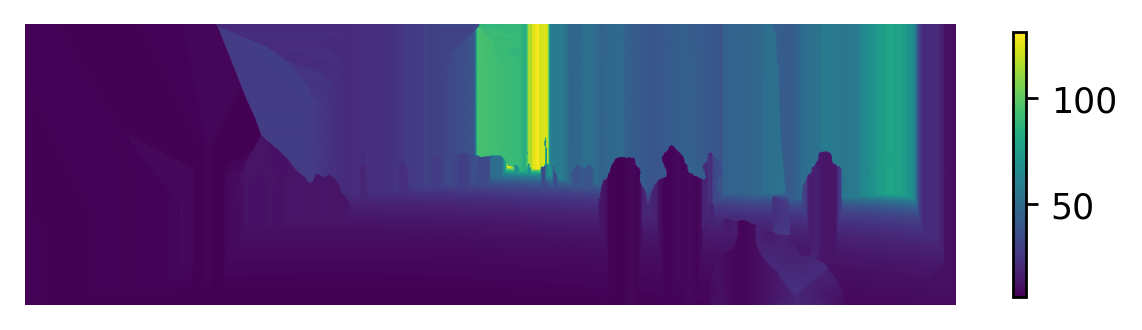

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from skimage.measure import label

def inpaint_individual_objects(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label_val in unique_labels:
        object_mask = (sem_seg_image == label_val)
        
        # Apply connected-component labeling
        labeled_image, num_features = label(object_mask, connectivity=2, return_num=True)
        
        for i in range(1, num_features + 1):
            single_object_mask = (labeled_image == i)
            object_depth = inpainted_img * single_object_mask
            
            non_zero_object_depth = object_depth[single_object_mask]
            if np.any(non_zero_object_depth):
                # Create a binary mask of zero-valued pixels for the object
                object_zero_mask = (object_depth == 0).astype(np.uint8)
                
                # Ensure the object depth is a supported data type for cv2.inpaint
                object_depth_32f = object_depth.astype(np.float32)
                
                # Inpaint the object using the Telea method
                inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
                
                # Update the inpainted image with the inpainted object
                inpainted_img[single_object_mask] = inpainted_object[single_object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_individual_objects(final_depth_map, sem_seg_image)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

### Step 5: Apply Connected Components: To apply inpainting logic for each individual object

Label: 7, Number of features: 6


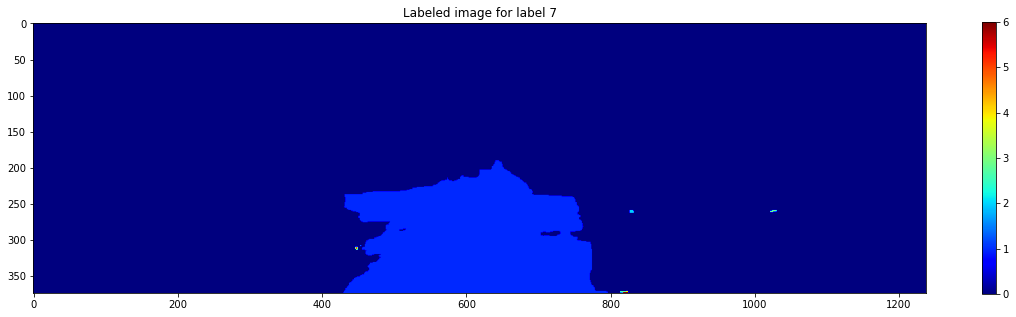

Label: 8, Number of features: 14


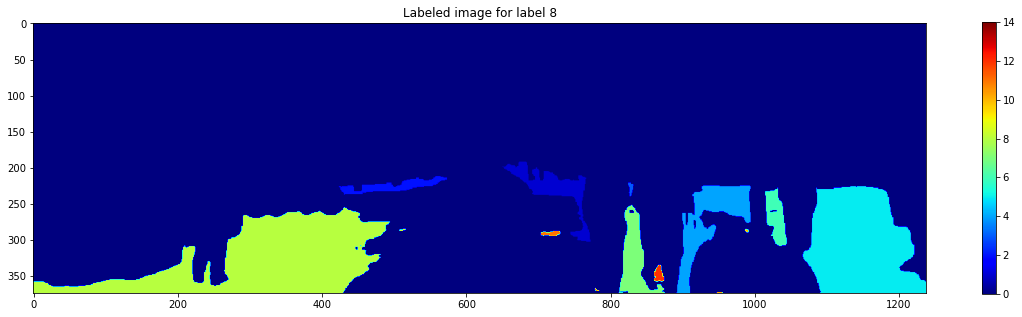

Label: 11, Number of features: 5


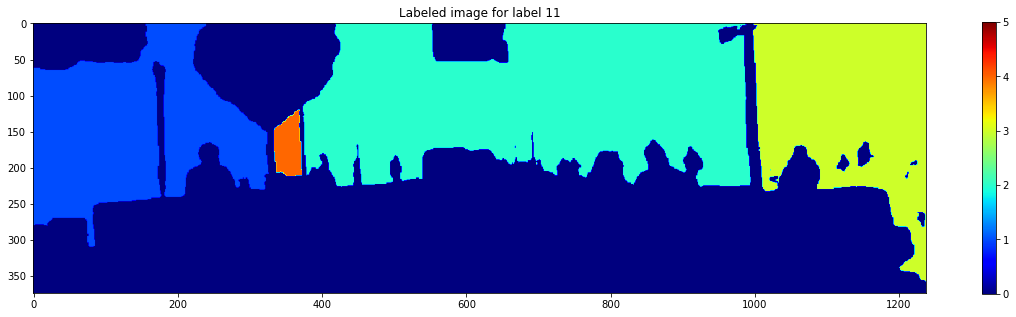

Label: 12, Number of features: 2


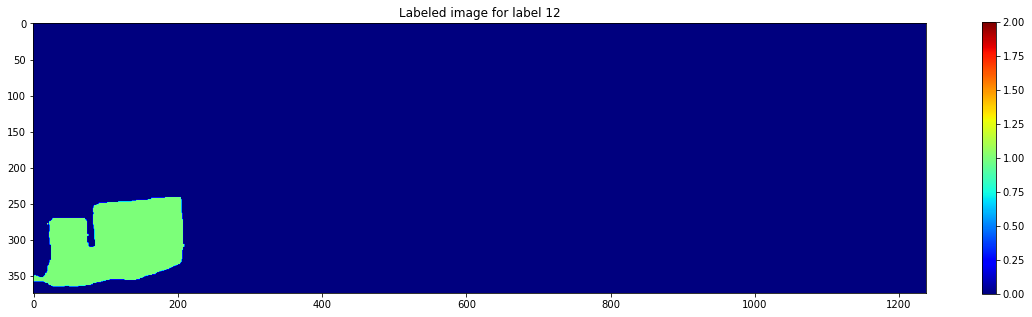

Label: 17, Number of features: 12


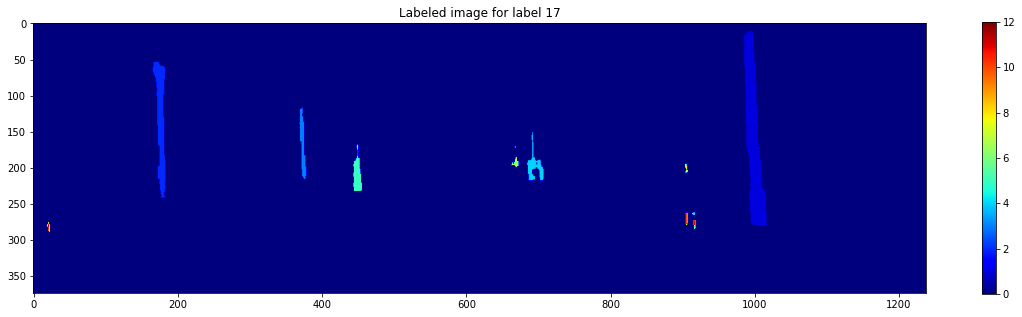

Label: 20, Number of features: 6


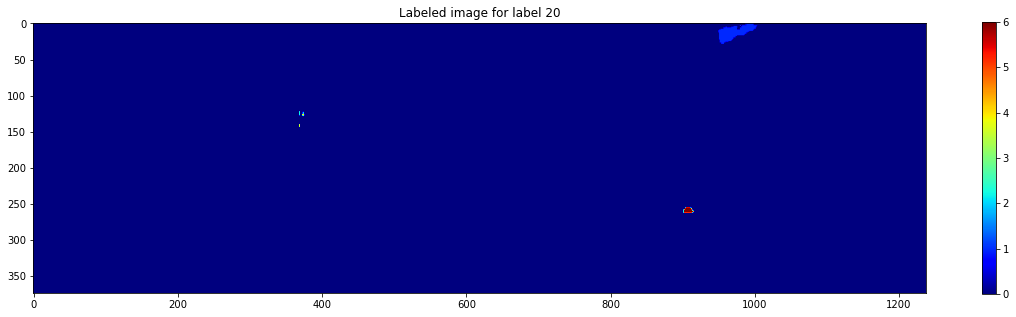

Label: 21, Number of features: 2


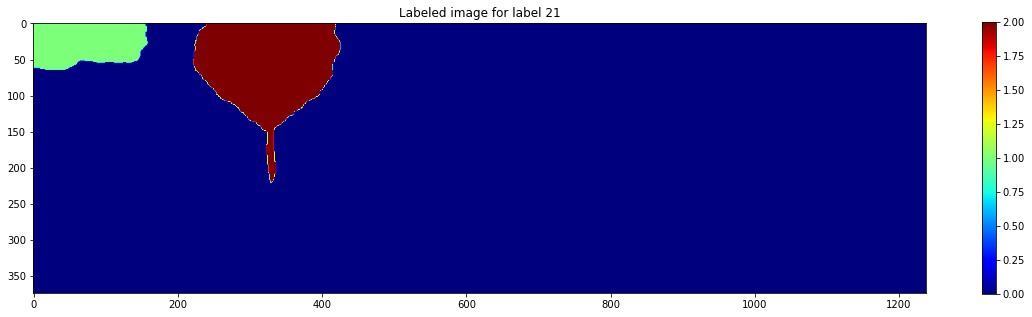

Label: 23, Number of features: 1


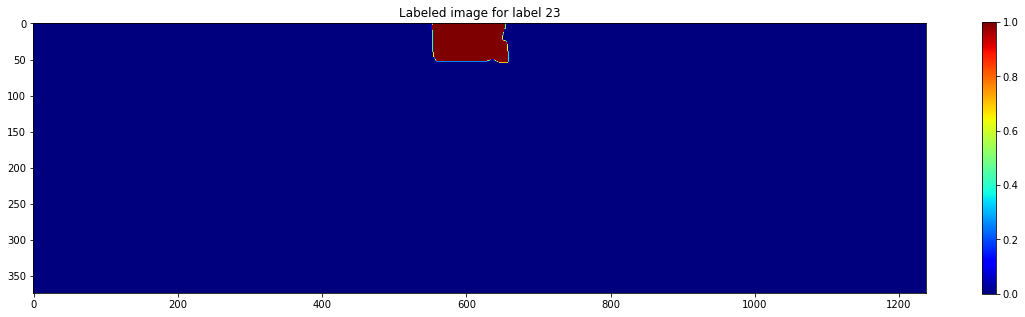

Label: 24, Number of features: 15


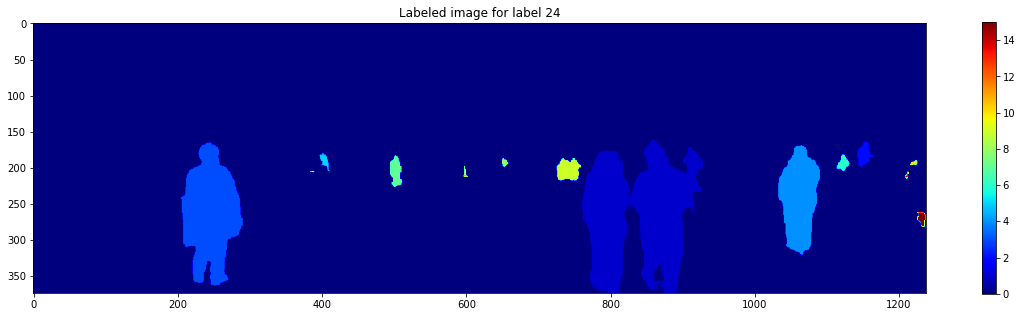

Label: 25, Number of features: 1


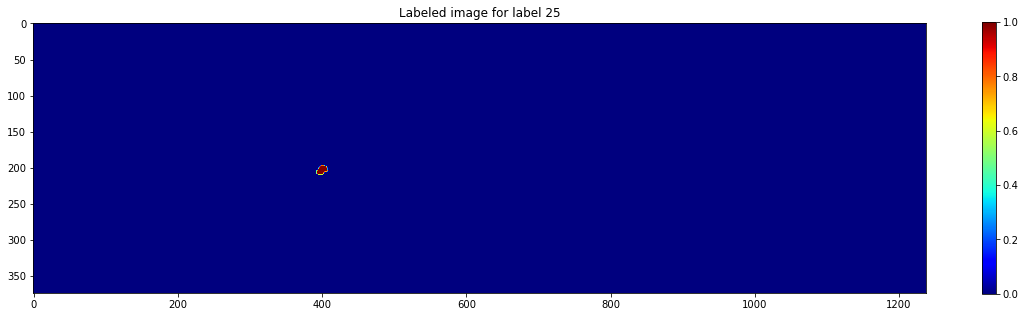

Label: 26, Number of features: 2


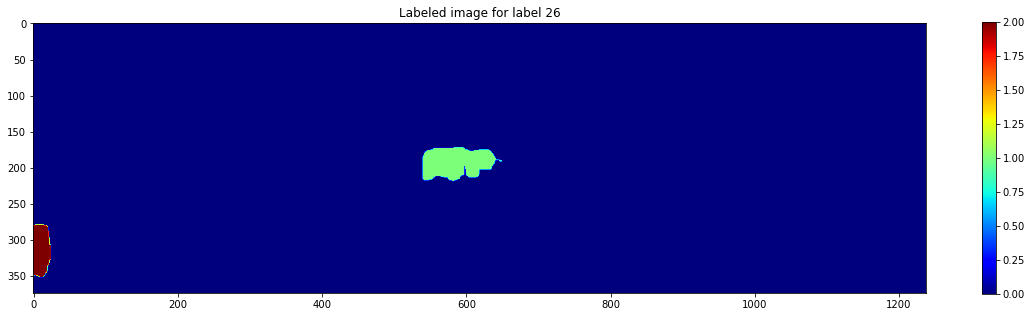

Label: 33, Number of features: 6


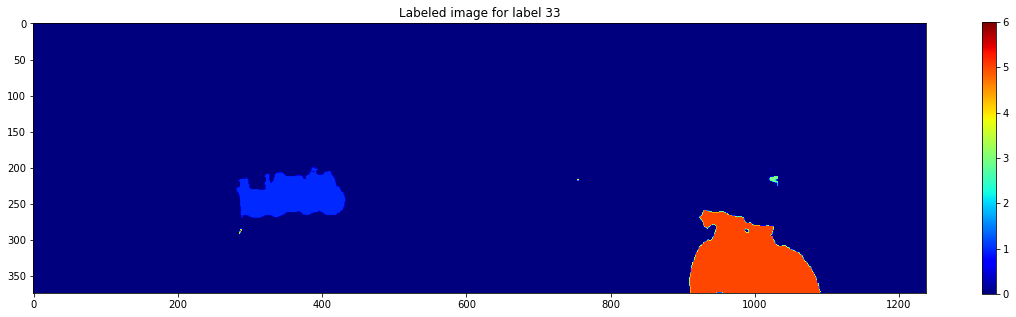

Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  130.7589


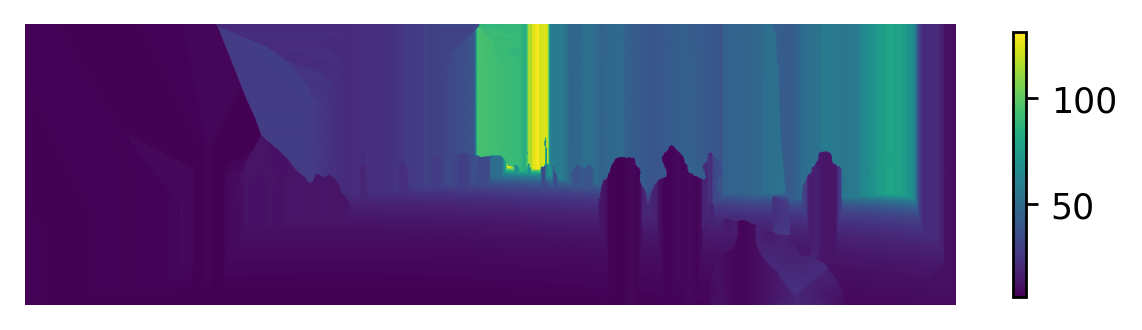

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from skimage.measure import label

def inpaint_individual_objects(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label_val in unique_labels:
        object_mask = (sem_seg_image == label_val)
        
        # Apply connected-component labeling
        labeled_image, num_features = label(object_mask, connectivity=2, return_num=True)
        
        print(f'Label: {label_val}, Number of features: {num_features}')  # Output number of features
        
        # Visualize the labeled image for each label with increased figure size
        plt.figure(figsize=(20, 10))
        plt.title(f'Labeled image for label {label_val}')
        img_plot = plt.imshow(labeled_image, cmap='jet')
        # Reduce the size of the colorbar
        plt.colorbar(img_plot, shrink=0.5)
        plt.show()
        
        for i in range(1, num_features + 1):
            single_object_mask = (labeled_image == i)
            object_depth = inpainted_img * single_object_mask
            
            non_zero_object_depth = object_depth[single_object_mask]
            if np.any(non_zero_object_depth):
                # Create a binary mask of zero-valued pixels for the object
                object_zero_mask = (object_depth == 0).astype(np.uint8)
                
                # Ensure the object depth is a supported data type for cv2.inpaint
                object_depth_32f = object_depth.astype(np.float32)
                
                # Inpaint the object using the Telea method
                inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
                
                # Update the inpainted image with the inpainted object
                inpainted_img[single_object_mask] = inpainted_object[single_object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_individual_objects(final_depth_map, sem_seg_image)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

### * Connected Components on Edge Connected Image for reference*

Label: 7, Number of features: 6


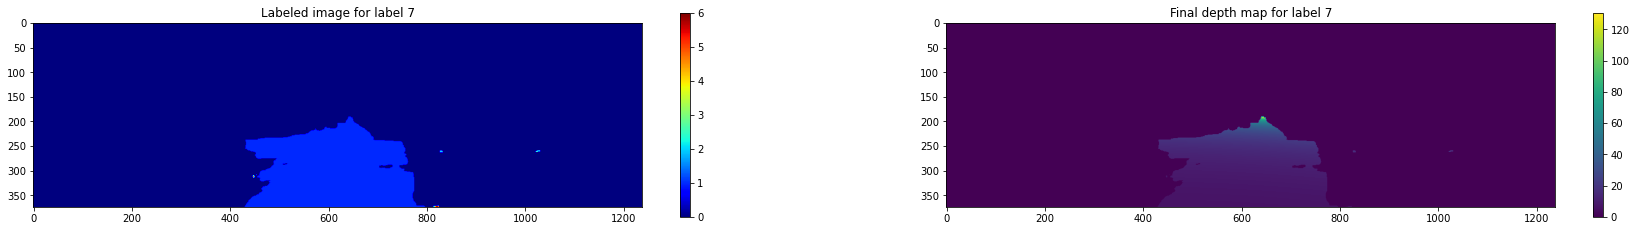

Label: 8, Number of features: 14


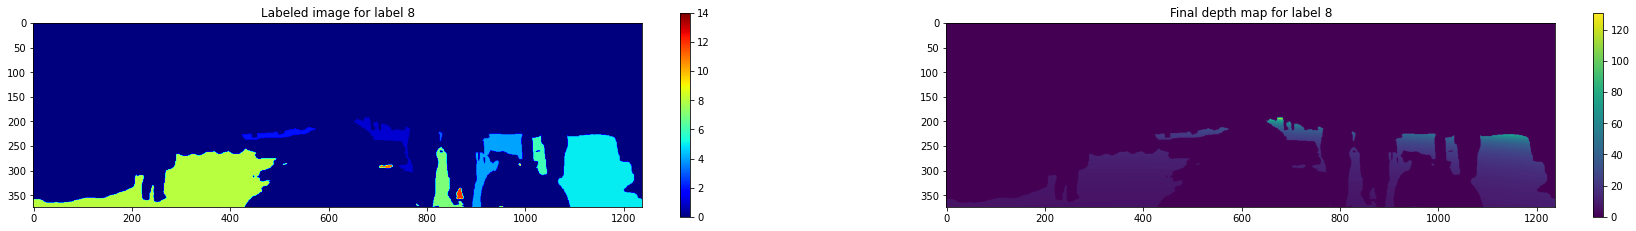

Label: 11, Number of features: 5


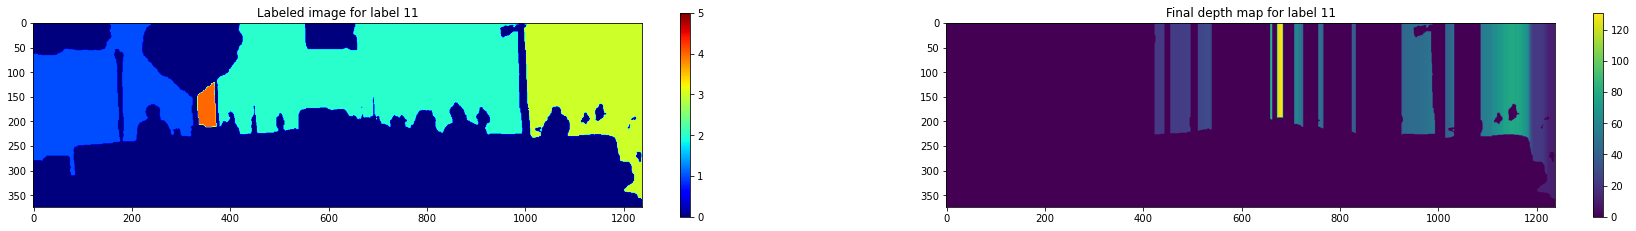

Label: 12, Number of features: 2


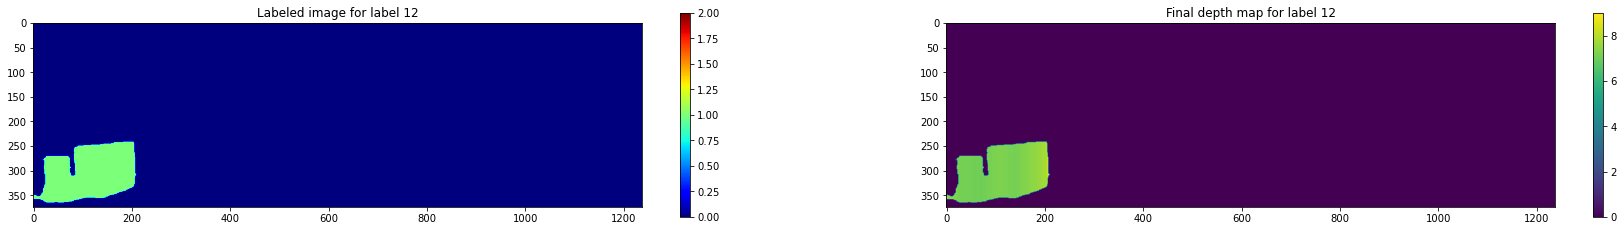

Label: 17, Number of features: 12


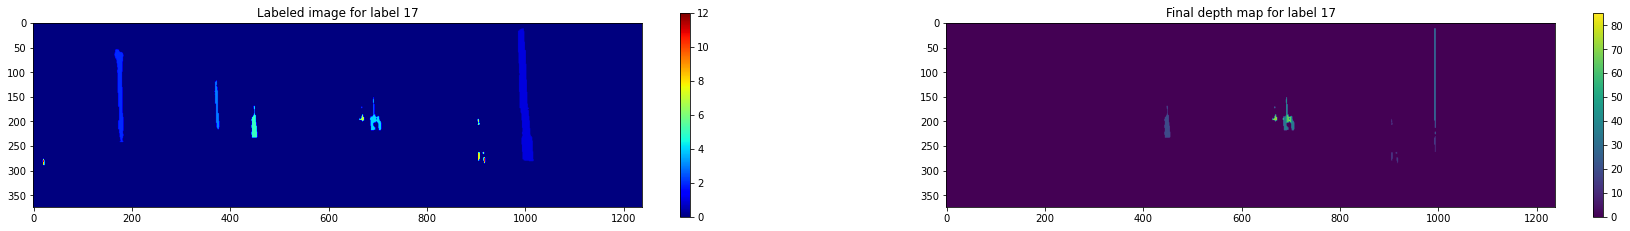

Label: 20, Number of features: 6


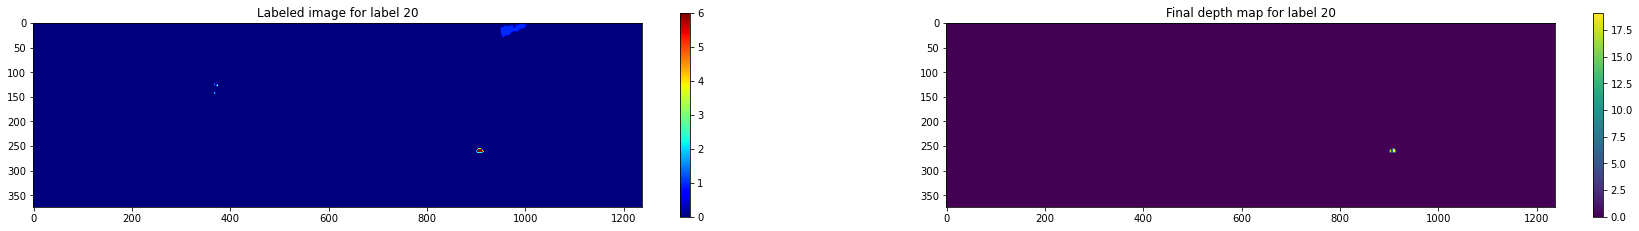

Label: 21, Number of features: 2


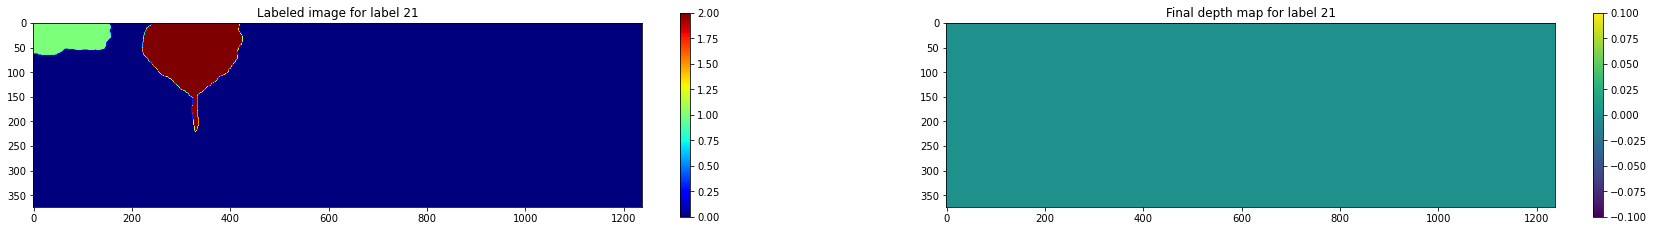

Label: 23, Number of features: 1


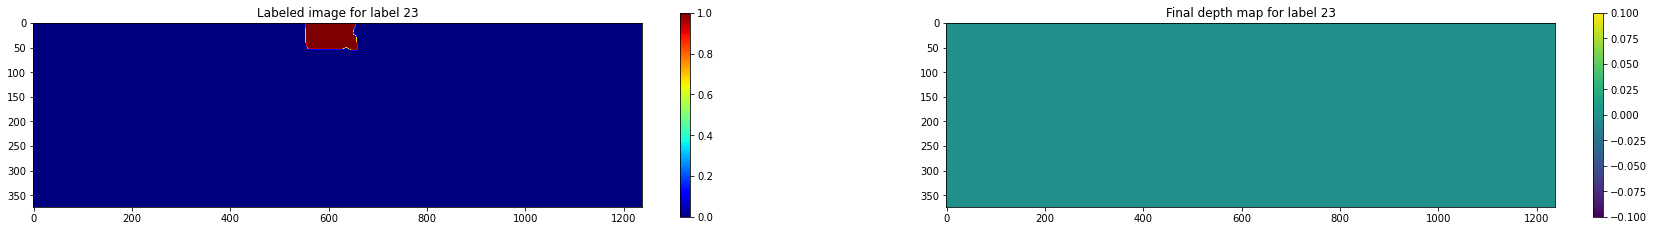

Label: 24, Number of features: 15


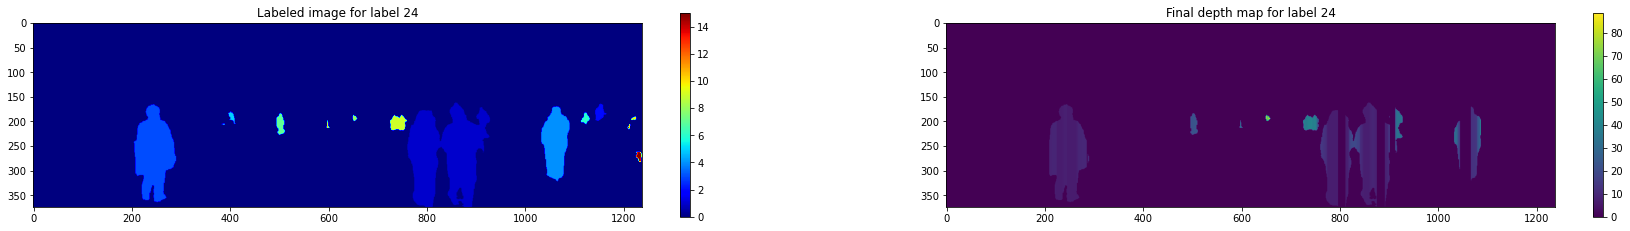

Label: 25, Number of features: 1


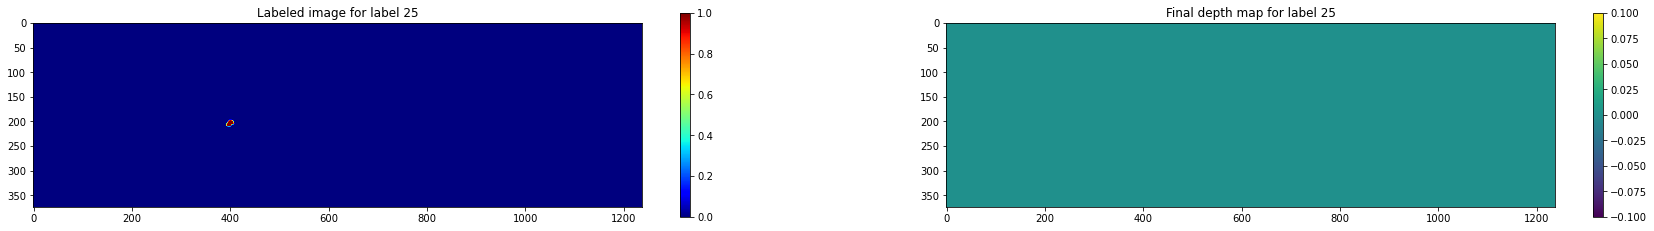

Label: 26, Number of features: 2


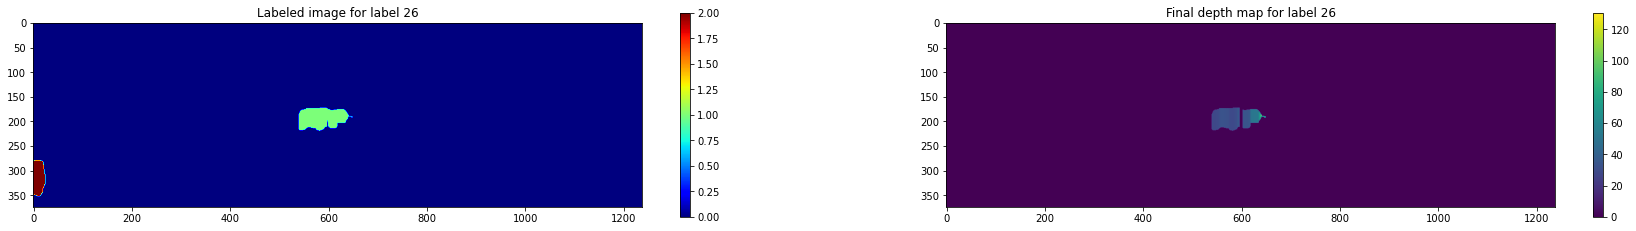

Label: 33, Number of features: 6


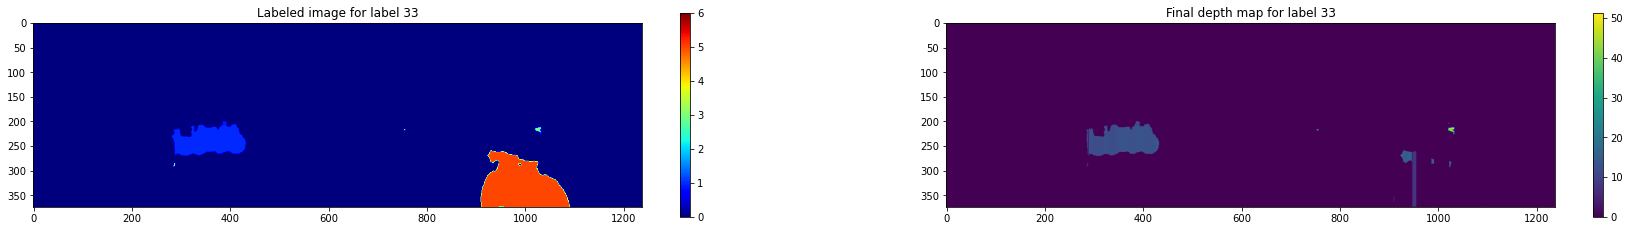

Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  130.7589


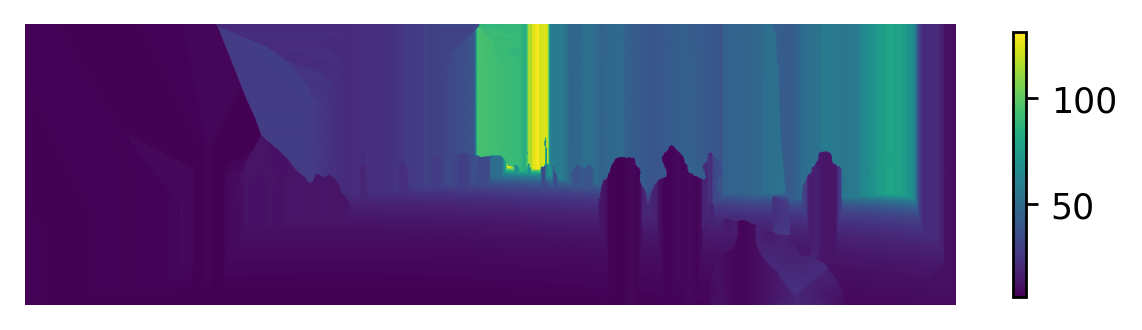

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from skimage.measure import label

def inpaint_individual_objects(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label_val in unique_labels:
        object_mask = (sem_seg_image == label_val)
        
        # Apply connected-component labeling
        labeled_image, num_features = label(object_mask, connectivity=2, return_num=True)
        
        print(f'Label: {label_val}, Number of features: {num_features}')  # Output number of features
        
        # Visualize the labeled image for each label with increased figure size
        plt.figure(figsize=(30, 15))
        
        # Subplot 1: Labeled image
        plt.subplot(1, 2, 1)
        plt.title(f'Labeled image for label {label_val}')
        img_plot = plt.imshow(labeled_image, cmap='jet')
        plt.colorbar(img_plot, shrink=0.25)
        
        # Subplot 2: Final depth map for the label
        plt.subplot(1, 2, 2)
        plt.title(f'Final depth map for label {label_val}')
        depth_plot = plt.imshow(inpainted_img * object_mask)
        plt.colorbar(depth_plot, shrink=0.25)
        
        plt.show()
        
        for i in range(1, num_features + 1):
            single_object_mask = (labeled_image == i)
            object_depth = inpainted_img * single_object_mask
            
            non_zero_object_depth = object_depth[single_object_mask]
            if np.any(non_zero_object_depth):
                # Create a binary mask of zero-valued pixels for the object
                object_zero_mask = (object_depth == 0).astype(np.uint8)
                
                # Ensure the object depth is a supported data type for cv2.inpaint
                object_depth_32f = object_depth.astype(np.float32)
                
                # Inpaint the object using the Telea method
                inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
                
                # Update the inpainted image with the inpainted object
                inpainted_img[single_object_mask] = inpainted_object[single_object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_individual_objects(final_depth_map, sem_seg_image)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

### Step 6: Telea + Nearest Neighbor Inpainting on Connected Components (within each object separately)

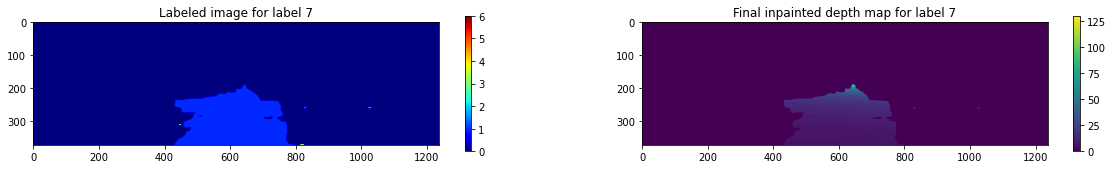

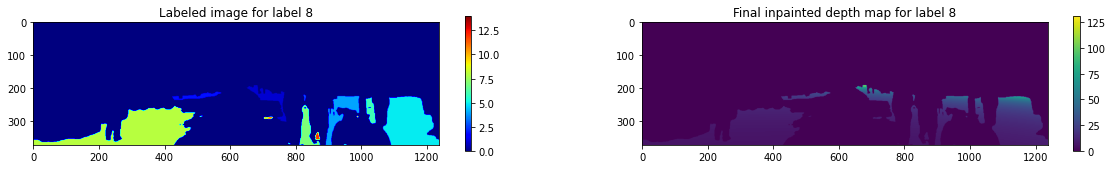

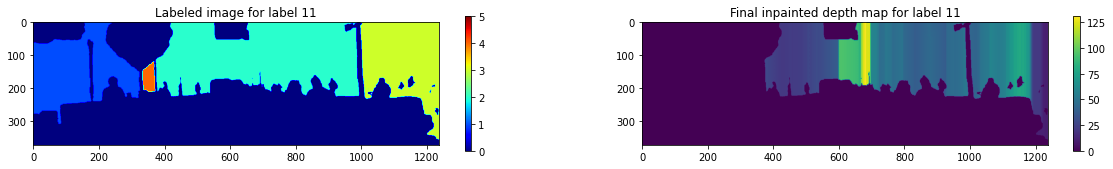

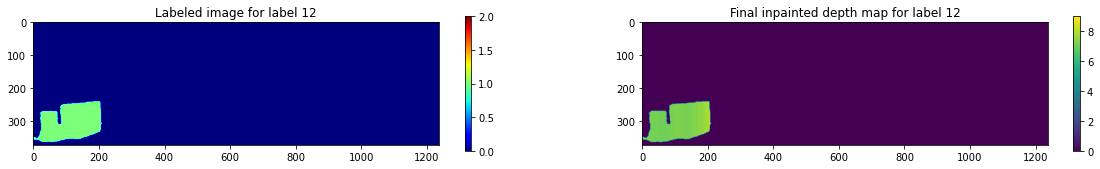

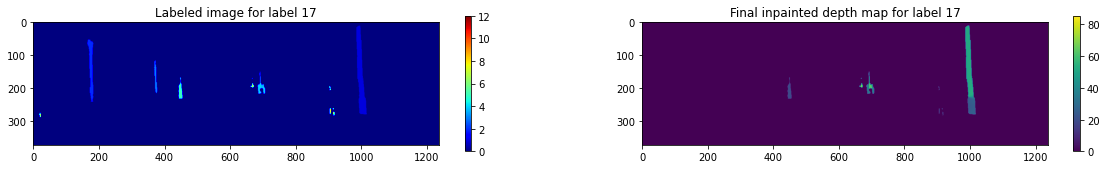

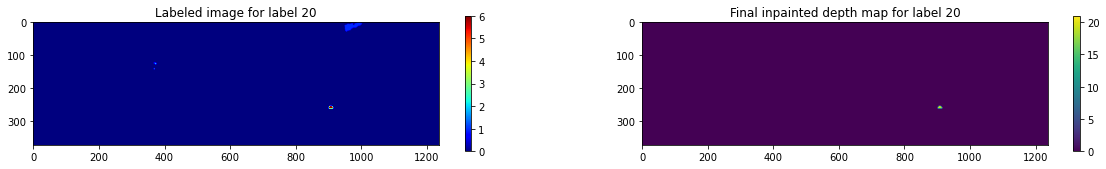

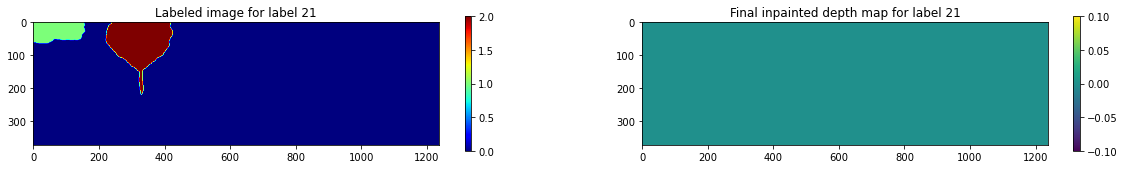

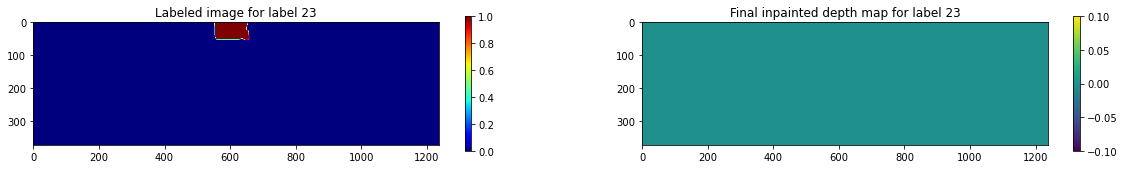

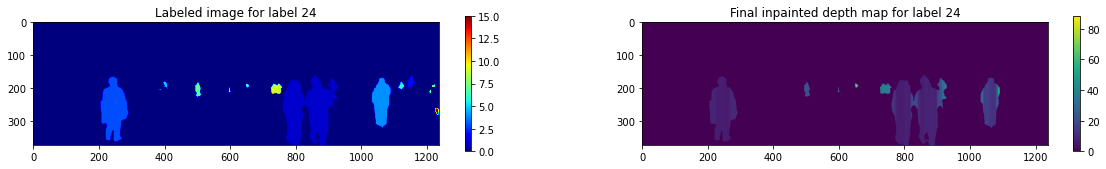

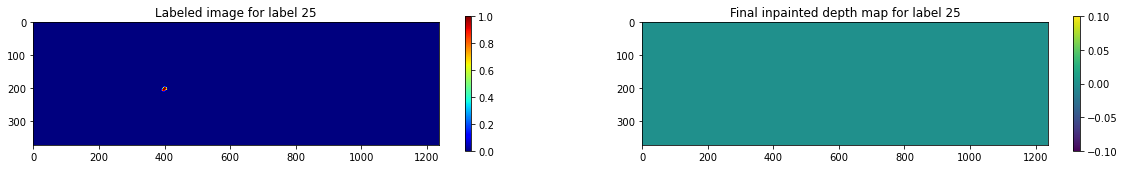

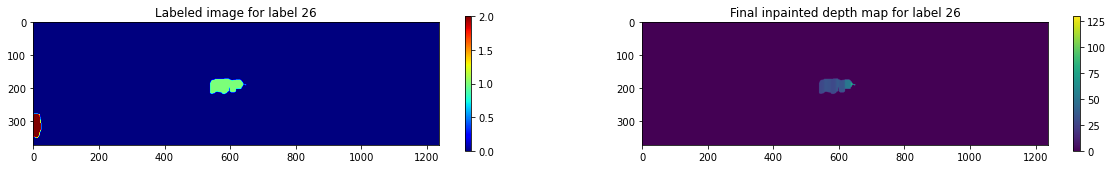

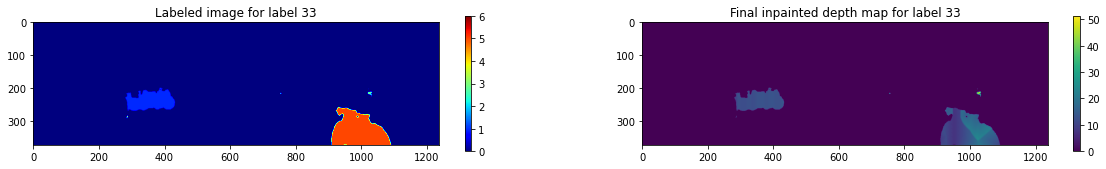

Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  130.7589


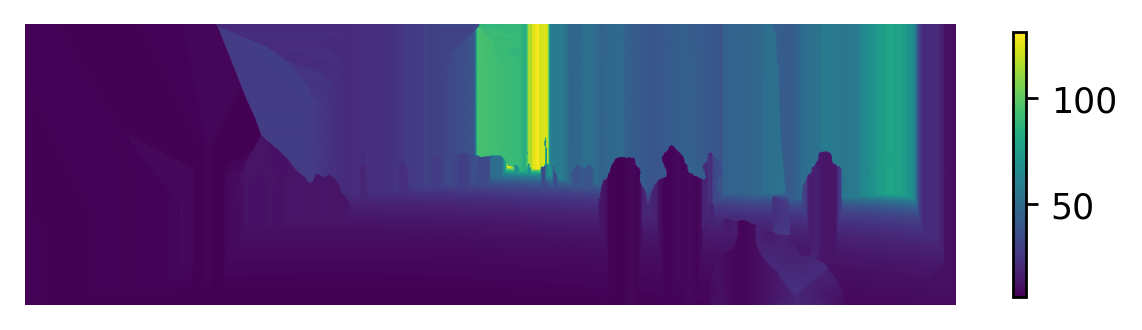

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from skimage.measure import label

def inpaint_individual_objects(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label_val in unique_labels:
        object_mask = (sem_seg_image == label_val)
        
        # Apply connected-component labeling
        labeled_image, num_features = label(object_mask, connectivity=2, return_num=True)
        
        # Create an empty array to store the final inpainted depth map for this label
        final_depth_for_label = np.zeros_like(inpainted_img)
        
        for i in range(1, num_features + 1):
            single_object_mask = (labeled_image == i)
            object_depth = inpainted_img * single_object_mask
            
            non_zero_object_depth = object_depth[single_object_mask]
            if np.any(non_zero_object_depth):
                # Create a binary mask of zero-valued pixels for the object
                object_zero_mask = (object_depth == 0).astype(np.uint8)
                
                # Ensure the object depth is a supported data type for cv2.inpaint
                object_depth_32f = object_depth.astype(np.float32)
                
                # Inpaint the object using the Telea method
                inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
                
                # Update the final depth map for this label with the inpainted object
                final_depth_for_label[single_object_mask] = inpainted_object[single_object_mask]
        
        # Visualize the labeled image and the final inpainted depth map for this label
        plt.figure(figsize=(20, 10))
        
        # Subplot 1: Labeled image
        plt.subplot(1, 2, 1)
        plt.title(f'Labeled image for label {label_val}')
        img_plot = plt.imshow(labeled_image, cmap='jet')
        plt.colorbar(img_plot, shrink=0.25)
        
        # Subplot 2: Final inpainted depth map for the label
        plt.subplot(1, 2, 2)
        plt.title(f'Final inpainted depth map for label {label_val}')
        depth_plot = plt.imshow(final_depth_for_label)
        plt.colorbar(depth_plot, shrink=0.25)
        plt.show()
        
        # Update the inpainted image with the final inpainted depth map for this label
        inpainted_img[object_mask] = final_depth_for_label[object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_individual_objects(final_depth_map, sem_seg_image)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

### Step 6: Telea + Nearest Neighbor Inpainting + Connected Components + Fixed Sky Depth (200)

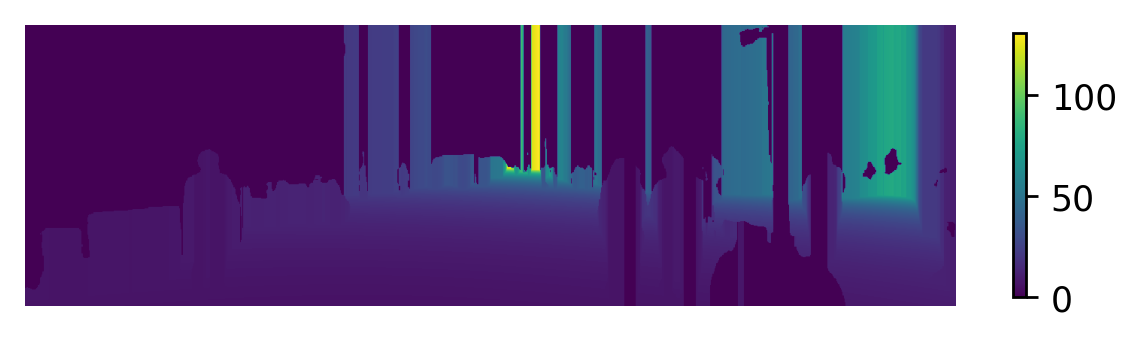

In [36]:
fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(final_depth_map)
plt.colorbar(shrink=0.35)
plt.show()

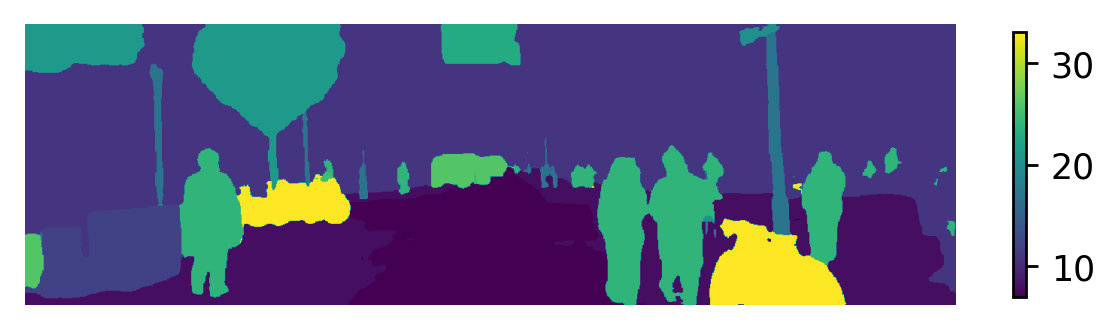

In [37]:
fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(sem_seg_image)
plt.colorbar(shrink=0.35)
plt.show()

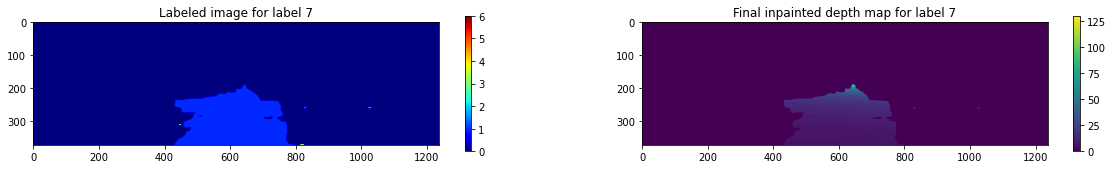

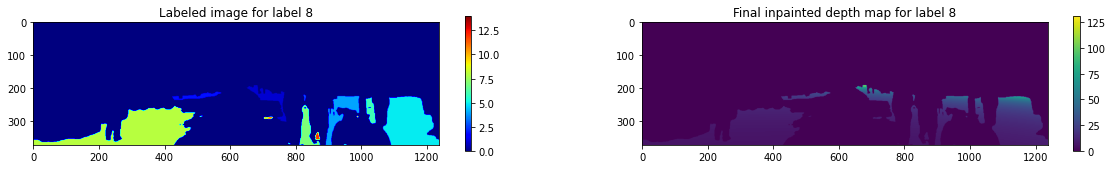

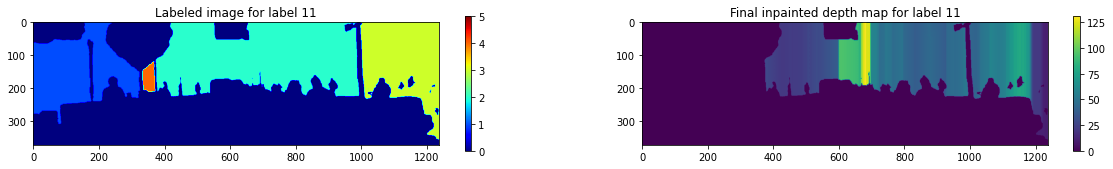

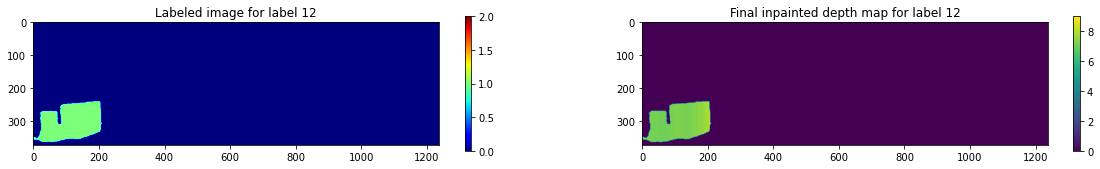

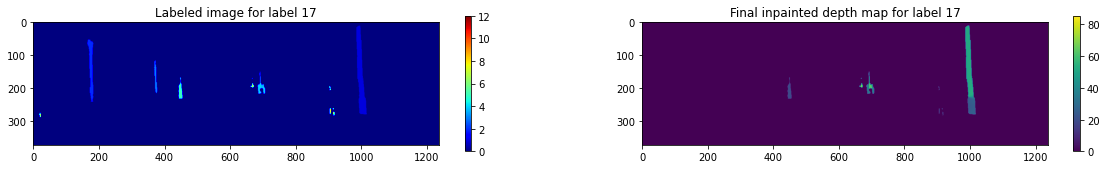

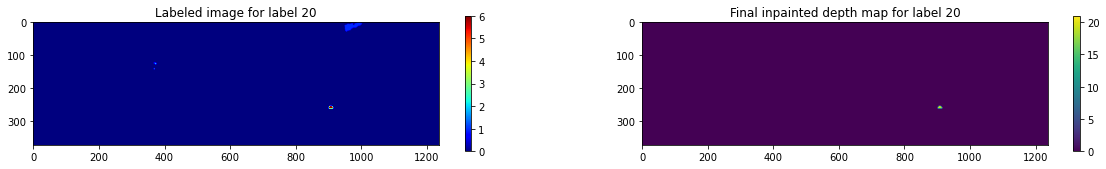

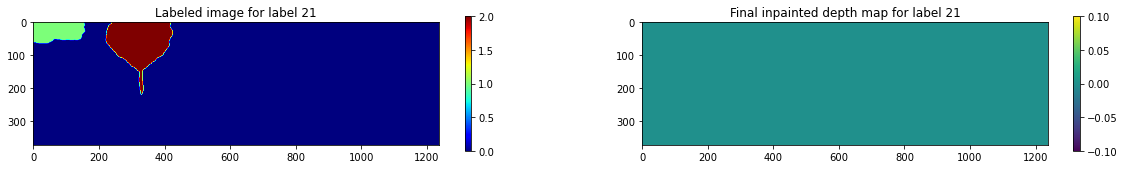

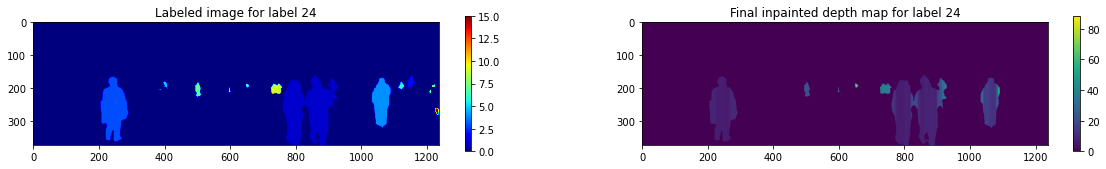

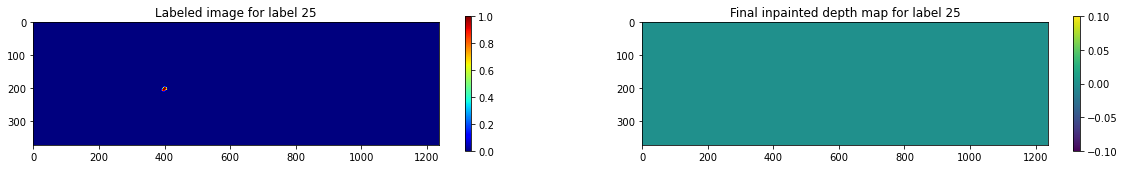

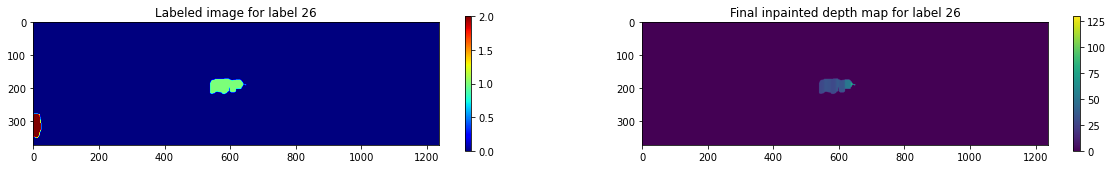

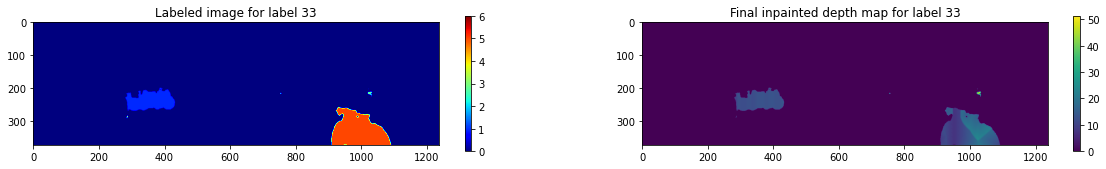

Min before inpainting:  0.0 Max before inpainting:  130.7589
Min after inpainting:  6.1972 Max after inpainting:  200.0


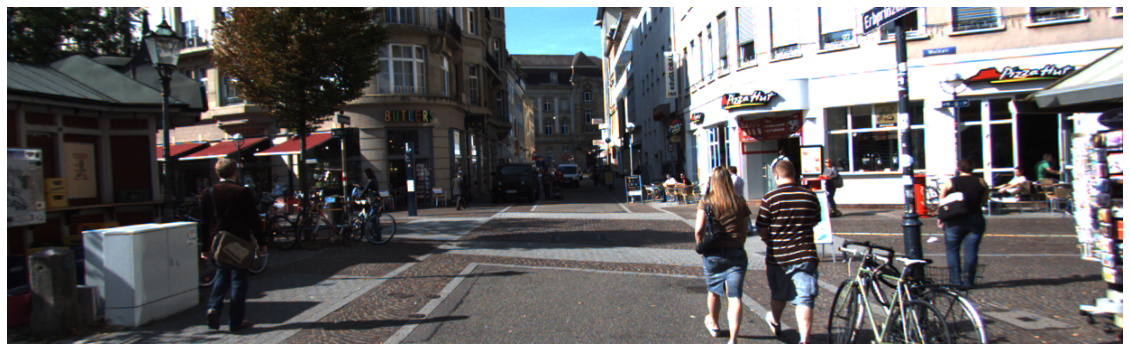

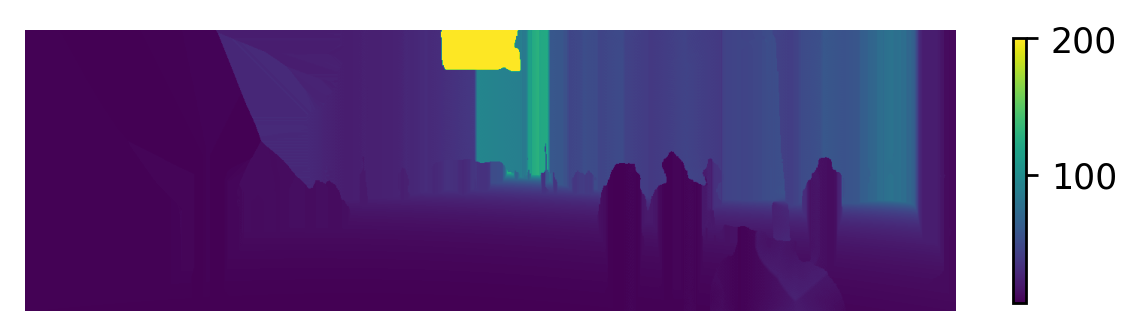

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from skimage.measure import label

def inpaint_individual_objects(img, sem_seg_image):
    inpainted_img = img.astype(np.float32) if img.dtype != np.float32 else img.copy()
    unique_labels = np.unique(sem_seg_image)
    
    for label_val in unique_labels:
        object_mask = (sem_seg_image == label_val)
        
        # Set all pixel's depth to 500 for label 23
        if label_val == 23:
            inpainted_img[object_mask] = 200.0
            continue  # Skip the rest of the code in this iteration
        
        # Apply connected-component labeling
        labeled_image, num_features = label(object_mask, connectivity=2, return_num=True)
        
        # Create an empty array to store the final inpainted depth map for this label
        final_depth_for_label = np.zeros_like(inpainted_img)

        for i in range(1, num_features + 1):
            single_object_mask = (labeled_image == i)
            object_depth = inpainted_img * single_object_mask
            
            non_zero_object_depth = object_depth[single_object_mask]
            if np.any(non_zero_object_depth):
                # Create a binary mask of zero-valued pixels for the object
                object_zero_mask = (object_depth == 0).astype(np.uint8)
                
                # Ensure the object depth is a supported data type for cv2.inpaint
                object_depth_32f = object_depth.astype(np.float32)
                
                # Inpaint the object using the Telea method
                inpainted_object = cv2.inpaint(object_depth_32f, object_zero_mask, 3, cv2.INPAINT_TELEA)
                
                # Update the final depth map for this label with the inpainted object
                final_depth_for_label[single_object_mask] = inpainted_object[single_object_mask]
        
        # Visualize the labeled image and the final inpainted depth map for this label
        plt.figure(figsize=(20, 10))
        
        # Subplot 1: Labeled image
        plt.subplot(1, 2, 1)
        plt.title(f'Labeled image for label {label_val}')
        img_plot = plt.imshow(labeled_image, cmap='jet')
        plt.colorbar(img_plot, shrink=0.25)
        
        # Subplot 2: Final inpainted depth map for the label
        plt.subplot(1, 2, 2)
        plt.title(f'Final inpainted depth map for label {label_val}')
        depth_plot = plt.imshow(final_depth_for_label)
        plt.colorbar(depth_plot, shrink=0.25)
        
        plt.show()
        
        # Update the inpainted image with the final inpainted depth map for this label
        inpainted_img[object_mask] = final_depth_for_label[object_mask]
    
    # After inpainting all objects, inpaint any remaining zero-valued pixels using the previous logic
    remaining_zero_pixels = np.where(inpainted_img == 0)
    if len(remaining_zero_pixels[0]) > 0:
        h, w = inpainted_img.shape[:2]
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        mask_non_zero = np.where(inpainted_img != 0)
        xym_non_zero = np.vstack((xx[mask_non_zero], yy[mask_non_zero])).T
        img_values_non_zero = inpainted_img[mask_non_zero]
        interp = NearestNDInterpolator(xym_non_zero, img_values_non_zero)
        inpainted_img[remaining_zero_pixels] = interp(remaining_zero_pixels[1], remaining_zero_pixels[0])
    
    return inpainted_img

# Assume final_depth_map is your input image and sem_seg_image is your semantic segmentation image
inpaint_depth = inpaint_individual_objects(final_depth_map, sem_seg_image)
print("Min before inpainting: ", np.min(final_depth_map), "Max before inpainting: ", np.max(final_depth_map))
print("Min after inpainting: ", np.min(inpaint_depth), "Max after inpainting: ", np.max(inpaint_depth))


import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_path = rgb_image_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the color image
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

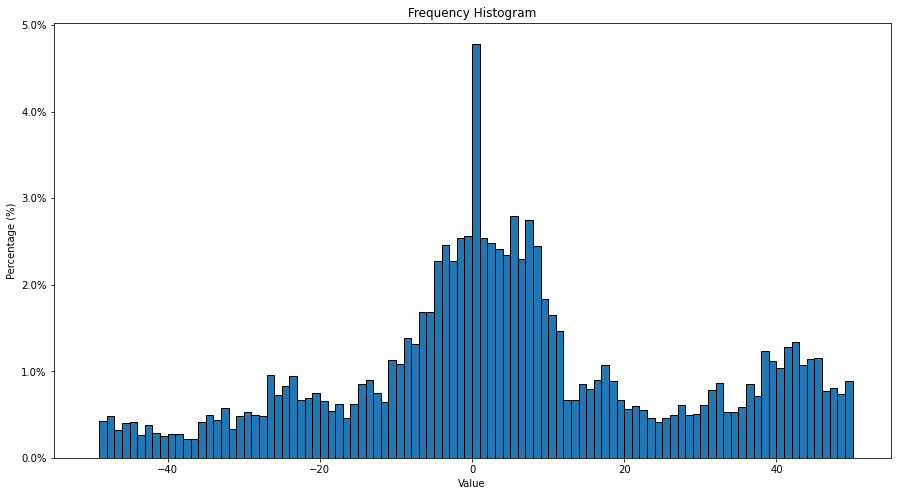

In [39]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Initialize frequency counter
freq_counter = Counter()

# Load Physics Depth
physics_depth_map = inpaint_depth
ld_depth_map = velodyne_depth_map_full_image

# Create an empty array with the same shape as the original depth maps
percentage_difference_map = np.zeros_like(ld_depth_map)

# Iterate over the depth maps
for i in range(ld_depth_map.shape[0]):
    for j in range(ld_depth_map.shape[1]):
        lidar_value = ld_depth_map[i, j]
        physics_value = physics_depth_map[i, j]

        # Check if either value is zero
        if lidar_value == 0 or physics_value == 0:
            percentage_difference = 0
        else:
            # Calculate the percentage difference and round to 2 decimals
            percentage_difference = round(((physics_value-lidar_value) / (physics_value)) * 100, 2)
            
        # Place the calculated value in the percentage difference map
        percentage_difference_map[i, j] = percentage_difference

# Flatten the array to work with 1D data
flattened_map = percentage_difference_map.flatten()

# Filter out zero values
non_zero_values = flattened_map[flattened_map != 0]

# Update frequency counter
for val in non_zero_values:
    if -50 < val < 50:
        freq_counter[int(val)] += 1

# Print and save frequency
total_count = sum(freq_counter.values())

for i in range(-50, 50):
    count = freq_counter.get(i, 0)
    #print(f"Range ({i}, {i+1}): {count} values")

# Plot histogram
plt.figure(figsize=(15, 8))  # Increase the size of the histogram
plt.hist(list(freq_counter.elements()), bins=range(-50, 51), edgecolor='black', density=True)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))

plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Frequency Histogram')
plt.show()

### Rough Work

(374, 1238)


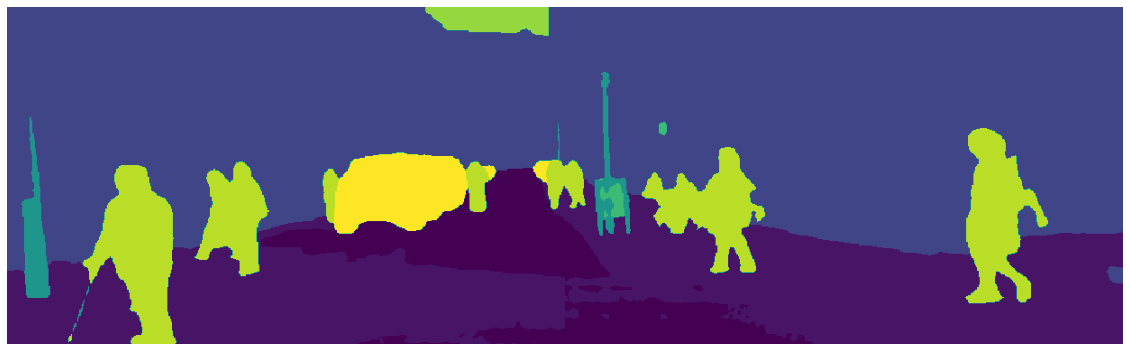

(374, 1238)


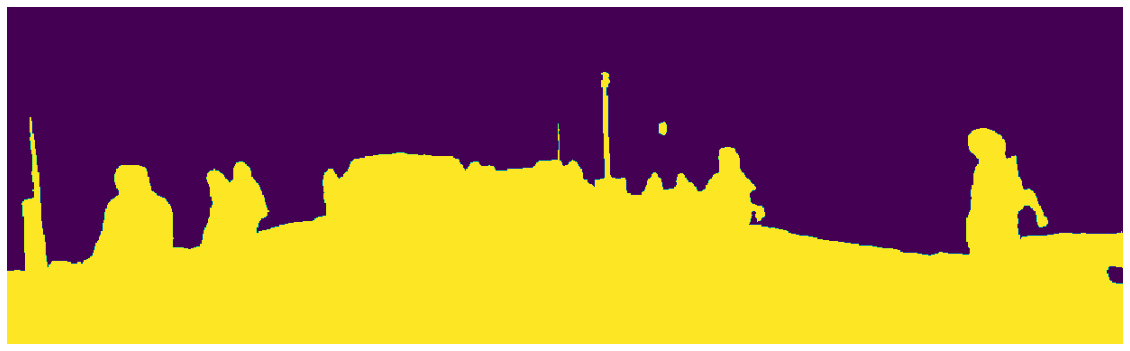

In [53]:
# [11 17 20 24 26]
# ground_labels = [6, 7, 8, 9, 10, 22]

import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load Image
image_path = seg_image_path
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

#Resize
new_size = (1238, 374)
resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

# Display the masked color image
print(resized_image.shape)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(resized_image)
plt.axis('off')
plt.show()

ground_labels = [6, 7, 8, 9, 10, 22, 17, 20, 24, 26]
# Create a masked image where all values except ground_labels are set to 0
Sem_gray_image_road = np.where(np.isin(resized_image, ground_labels), 7, 0)

# Display the masked color image
print(Sem_gray_image_road.shape)
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(Sem_gray_image_road)
plt.axis('off')
plt.show()

(374, 1238)


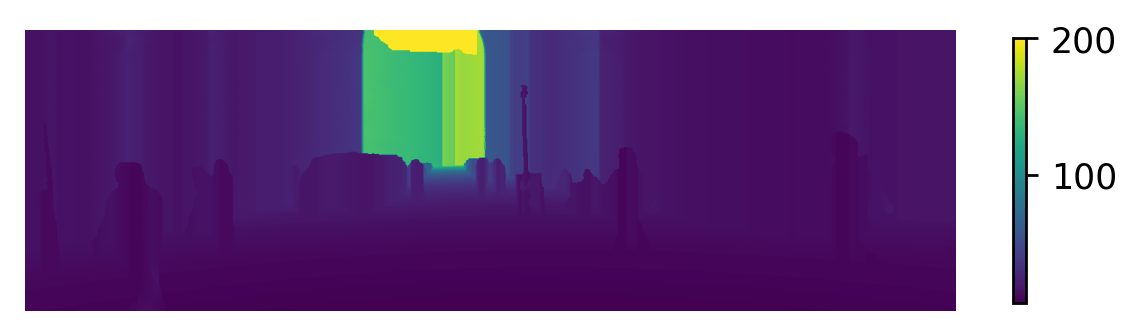

In [54]:
print(inpaint_depth.shape)
fig = plt.figure(dpi=250)
plt.axis('off')
plt.imshow(inpaint_depth)  # Assuming the image is grayscale
plt.colorbar(shrink=0.35)
plt.show()

Data Type: <class 'numpy.ndarray'>
Shape:  (374, 1238)
Min Depth:  0.0
Max Depth:  175.237
Mean Depth:  5.008053


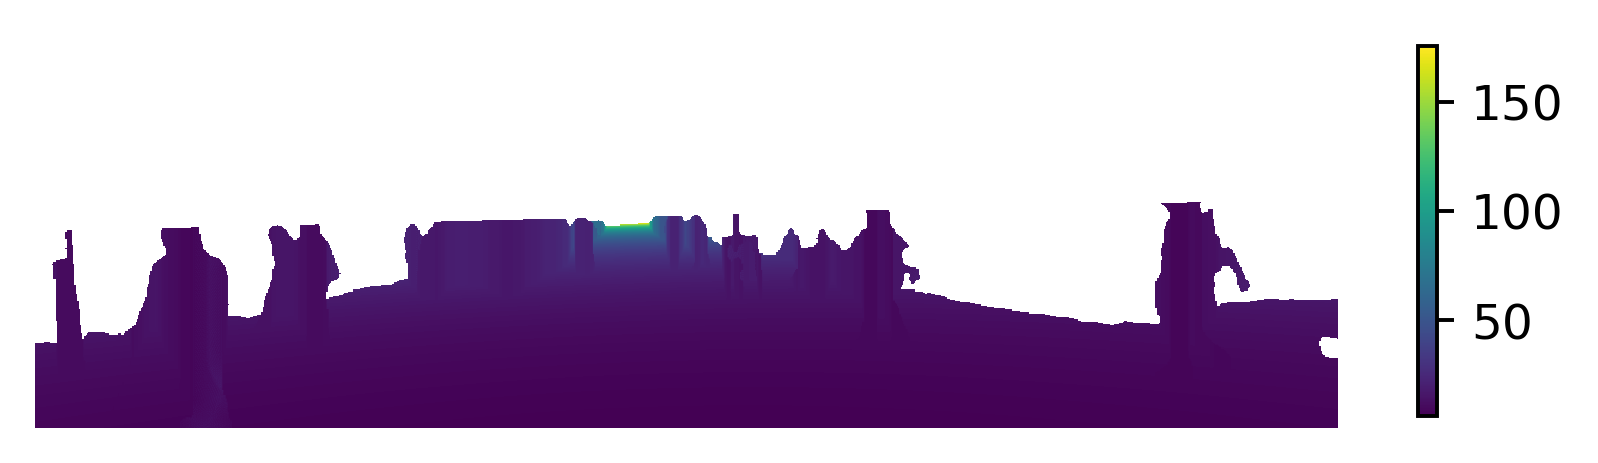

In [55]:
# Perform the pixel-wise operation to make non-road pixels depth and negative depth as 0
phy_depth_map_road=inpaint_depth.copy()

for i in range(Sem_gray_image_road.shape[0]):
    for j in range(Sem_gray_image_road.shape[1]):
        if  Sem_gray_image_road[i, j]!=7 or phy_depth_map_full_image[i, j]< 0:
            phy_depth_map_road[i, j] = 0

# Masking zeros
masked_image = np.ma.masked_where((phy_depth_map_road == 0)|(phy_depth_map_road==0), phy_depth_map_road) # For Visualization Purpose

# Display
print("Data Type:", type(phy_depth_map_road))
print("Shape: ", phy_depth_map_road.shape)
print("Min Depth: ", phy_depth_map_road.min())
print("Max Depth: ",phy_depth_map_road.max())
print("Mean Depth: ",phy_depth_map_road.mean())

fig = plt.figure(dpi=350)
plt.axis('off')
plt.imshow(masked_image)
plt.colorbar(shrink=0.35)
plt.show()

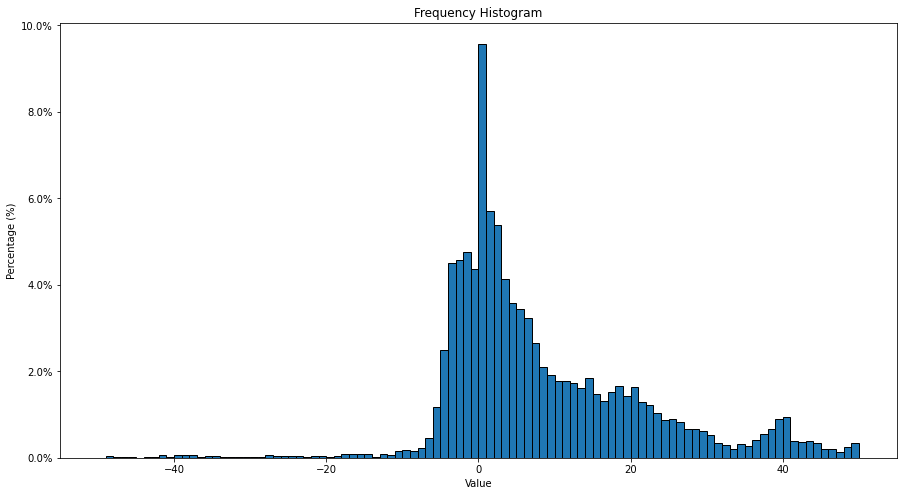

In [56]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Initialize frequency counter
freq_counter = Counter()

# Load Physics Depth
physics_depth_map = phy_depth_map_road
ld_depth_map = velodyne_depth_map_full_image

# Create an empty array with the same shape as the original depth maps
percentage_difference_map = np.zeros_like(ld_depth_map)

# Iterate over the depth maps
for i in range(ld_depth_map.shape[0]):
    for j in range(ld_depth_map.shape[1]):
        lidar_value = ld_depth_map[i, j]
        physics_value = physics_depth_map[i, j]

        # Check if either value is zero
        if lidar_value == 0 or physics_value == 0:
            percentage_difference = 0
        else:
            # Calculate the percentage difference and round to 2 decimals
            percentage_difference = round(((physics_value-lidar_value) / (physics_value)) * 100, 2)
            
        # Place the calculated value in the percentage difference map
        percentage_difference_map[i, j] = percentage_difference

# Flatten the array to work with 1D data
flattened_map = percentage_difference_map.flatten()

# Filter out zero values
non_zero_values = flattened_map[flattened_map != 0]

# Update frequency counter
for val in non_zero_values:
    if -50 < val < 50:
        freq_counter[int(val)] += 1

# Print and save frequency
total_count = sum(freq_counter.values())

for i in range(-50, 50):
    count = freq_counter.get(i, 0)
    #print(f"Range ({i}, {i+1}): {count} values")

# Plot histogram
plt.figure(figsize=(15, 8))  # Increase the size of the histogram
plt.hist(list(freq_counter.elements()), bins=range(-50, 51), edgecolor='black', density=True)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))

plt.xlabel('Value')
plt.ylabel('Percentage (%)')
plt.title('Frequency Histogram')
plt.show()

(374, 1238)
